# Intro

In [1]:
import random
import os
import math
from functools import partial
from pathlib import Path
import librosa
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchaudio
from sklearn import metrics
from scipy import signal
from scipy.signal import hilbert, convolve
from scipy.signal.windows import hann
from tn_ev_func_utils import load_cbin, load_notmat, readrecf, bandpass_filtfilt, smooth_data, segment_song

if "sox_io" in torchaudio.backend.list_audio_backends():
    if torchaudio.get_audio_backend() != 'sox_io':
        torchaudio.set_audio_backend('sox_io')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Numpy: {np.__version__}\nTorch: {torch.__version__}\nTorchAudio: {torchaudio.__version__}\nLibrosa: {librosa.__version__}")
print(f"Using {DEVICE}, {torch.cuda.get_device_name()}")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Numpy: 1.23.5
Torch: 2.0.0
TorchAudio: 2.0.0
Librosa: 0.10.0.post2
Using cuda, NVIDIA RTX A6000


# Utils

In [2]:
def normalize(x, a=-1, b=1):
    x = (b - a) * ((x - x.min()) / max((x.max() - x.min(), 1e-9))) + a
    return x

In [3]:
class RiseRunDecayScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, steps_in_epoch=None, warmup=1, constant=0, total_epochs=100, lowest_lr=1e-6):

        self.warmup = warmup * steps_in_epoch
        self.constant = self.warmup + (constant * steps_in_epoch)
        self.final_step = total_epochs * steps_in_epoch
        self.decay_interval = self.final_step - self.constant
        self.lowest_lr = lowest_lr
        super().__init__(optimizer)

    def get_lr(self):
        # not last_epoch, it's last_step, but that's pytorch convention ^~^
        current_iteration = self.last_epoch
        if current_iteration <= self.warmup:
            factor = current_iteration / self.warmup
        elif current_iteration <= self.constant:
            factor = 1.0
        else:
            current_iteration = self.last_epoch - self.constant
            factor = 0.5 * (1 + np.cos(np.pi * current_iteration / self.decay_interval))

        return [lr * factor if (lr * factor) > self.lowest_lr else self.lowest_lr for lr in self.base_lrs]

In [4]:
def bxe_with_ignore(logits, y_true, pos_weight=None, ignore=-1.0):
    idx = torch.where(y_true != ignore)
    logits = logits[idx]
    y_true = y_true[idx]
    loss = nn.functional.binary_cross_entropy_with_logits(logits, y_true, pos_weight=pos_weight)
    return loss

In [5]:
@torch.no_grad()
def update_teacher(student_model, teacher_model, alpha=0.99):
    for teacher_param, student_param in zip(teacher_model.parameters(), student_model.parameters()):
        teacher_param.data = (teacher_param.data * alpha) + ((1.0 - alpha) * student_param.data.clone())

In [6]:
def sigmoid_rampup(current, rampup_length=100):
    """Exponential rampup from https://arxiv.org/abs/1610.02242"""
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

In [ ]:
def plot_history(history, bird='', model_type='Supervised'):
    names = list(history.keys())
    fig, axs = plt.subplots(2, 3, figsize=(18, 6))
    fig.suptitle(f'{model_type} Framewise Segmentation of {bird}')
    for i, name in enumerate(names):
        values = history[name]
        r, c = divmod(i, 3)
        axs[r, c].plot(history[name], c='blue', label=name)
        if 'loss' in name:
            bestpoint = np.min(history[name])
            argbestpoint = np.argmin(history[name])
        else:
            bestpoint = np.max(history[name])
            argbestpoint = np.argmax(history[name])
        axs[r, c].plot(argbestpoint, bestpoint, c='red', marker='d', markersize=10)
        axs[r, c].grid(True)
        axs[r, c].legend()
    plt.tight_layout()
    plt.show()

In [8]:
def highpass_butterworth(wave, cutoff=500, sr=None, order=40):
    sos = signal.butter(order, cutoff, btype="highpass", analog=False, output="sos", fs=sr)
    return signal.sosfiltfilt(sos, wave)

# Model

In [9]:
class ConvRNNSegmentor(nn.Module):
    def __init__(self,
                 chan1=32,
                 chan2=64,
                 chan3=64,
                 k_size=11,
                 bi=True,
                 emb_size=128,
                 n_rnn_layers=1,
                 p_dropout=0.4,
                 ):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv2d(1, chan1, 11, padding="same", bias=True), nn.LeakyReLU(), nn.MaxPool2d((8, 1), (8, 1)), nn.Dropout2d(p_dropout),
                                 nn.Conv2d(chan1, chan2, 5, padding="same", bias=True), nn.LeakyReLU(), nn.MaxPool2d((4, 1), (4, 1)), nn.Dropout2d(p_dropout),
                                 nn.Conv2d(chan2, chan3, 3, padding="same", bias=True), nn.LeakyReLU(), nn.MaxPool2d((2, 1), (2, 1)), nn.Dropout2d(p_dropout/2))
        self.rnn = nn.LSTM(256, emb_size, n_rnn_layers, batch_first=True, bidirectional=bi, dropout=0.25 if n_rnn_layers > 1 else 0)
        self.fc = nn.Linear(emb_size * 2 if bi else emb_size, 1)  # * 2 since bidirectional doubles the output size of rnn
        self.fc_drop = nn.Dropout1d(p_dropout)

    def forward(self, x):
        self.rnn.flatten_parameters()
        batch_size, channels, freq_bins, time_bins = x.shape
        x = self.cnn(x) # (B, 1, 256, T) -> (B, 64, 4, T)
        x = x.view(batch_size, 256, time_bins).transpose(1, 2)
        x, *_ = self.rnn(x)
        x = self.fc_drop(x.transpose(1, 2)).transpose(1, 2)
        x = self.fc(x)
        return x

In [10]:
@torch.no_grad()
def evaluate(model, dataloader):
    test_loss, y_true, y_pred = [], [], []
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss = bxe_with_ignore(logits, y, ignore=-1)
        test_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
        
    test_loss = np.mean(test_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    return test_loss, acc, f1, precision, recall, jaccard

# Thresholding Algorithm

https://github.com/NickleDave/evfuncs/tree/fb4c71b845b3d0274848ab134b4c587578401775

In [11]:
def get_labels_from_thresholding(file):
    x, sr_ = load_cbin(file)
    x = smooth_data(x, sr_)
    onsets_s, offsets_s = segment_song(x, sr_)
    frames =  math.ceil(x.shape[0] / 64)
    yhat = np.zeros(frames, dtype=np.float32)
    for on, off in zip(onsets_s, offsets_s):
        on = math.floor(sr_ * on / 64)
        off = math.floor(sr_ * off / 64)
        yhat[on-1] = 0  # prevent close consequative syllables (if any) attaching to each others due to round off in converting to frame index
        yhat[on:off+1] = 1.
    return yhat

In [12]:
def evaluate_bengalese_by_thresholding_B(files, hop=64):
    y_true, y_pred = [], []
    
    for file in files:
        file = file.as_posix()
        x, sr_ = load_cbin(file)
        notmat_dict = load_notmat(file)
        x = smooth_data(x, sr_)
        onsets_s, offsets_s = segment_song(x, sr_)
        
        frames =  math.ceil(x.shape[0] / hop)
        
        yhat = np.zeros(frames, dtype=np.float32)
        for on, off in zip(onsets_s, offsets_s):
            on = math.floor(sr_ * on / hop)
            off = math.floor(sr_ * off / hop)
            yhat[on-1] = 0
            yhat[on:off+1] = 1.
            
        y = np.zeros(frames, dtype=np.float32)
        for on, off in zip(notmat_dict["onsets"], notmat_dict["offsets"]):
            on = math.floor(sr_ * on / 1000 / hop)  # divided by 1000 to convert from miliseconds to seconds
            off = math.floor(sr_ * off / 1000 / hop)
            y[on-1] = 0
            y[on:off+1] = 1.
        y_true.append(y.tolist())
        y_pred.append(yhat.tolist())
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    return acc, f1, precision, recall, jaccard

In [13]:
def evaluate_bengalese_by_thresholding_A(files, hop=64):
    y_true, y_pred = [], []
    for file in files:
        file = file.as_posix()
        x, sr_ = load_cbin(file)
        notmat_dict = load_notmat(file)
        x = smooth_data(x, sr_)
        threshold = notmat_dict['threshold']
        min_syl_dur = notmat_dict['min_dur'] / 1000
        min_silent_dur = notmat_dict['min_int'] / 1000
        onsets_s, offsets_s = segment_song(x, sr_, threshold, min_syl_dur, min_silent_dur)
        
        frames =  math.ceil(x.shape[0] / hop)
        
        yhat = np.zeros(frames, dtype=np.float32)
        for on, off in zip(onsets_s, offsets_s):
            on = math.floor(sr_ * on / hop)
            off = math.floor(sr_ * off / hop)
            yhat[on-1] = 0
            yhat[on:off+1] = 1.
            
        y = np.zeros(frames, dtype=np.float32)
        for on, off in zip(notmat_dict["onsets"], notmat_dict["offsets"]):
            on = math.floor(sr_ * on / 1000 / hop)
            off = math.floor(sr_ * off / 1000 / hop)
            y[on-1] = 0
            y[on:off+1] = 1.
        y_true.append(y.tolist())
        y_pred.append(yhat.tolist())
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    return acc, f1, precision, recall, jaccard

In [30]:
def evaluate_bengalese_by_thresholding_C(files, hop=64):
    """
    This is a very simple and bare segmentation algorithm just to showcase the challenges of using fully automated thresholding without expertise in signal analysis and bird vocalization.
    """
    def get_coords_from_my_thresholding(x, threshold=None):
        syllable_coords = []
        active = False
        if threshold is None:  # adaptive
            threshold = x.mean()
        for i, value in enumerate(x):
            if value > threshold:  # if current value is a syllable based on the threshold, then:
                if active == False:  # if it is the first value of the syllable, then:
                    active = True  # set active to True to know we are in a syllable region
                    start = i  # save the starting point of the active area, recall that we are iterating the envelope, hence each position gets multiplied by the window size
                end = i  # keep track of the ending index
            elif active:  # else, if we were in a syllable region already and the current value is below the threshold, then:
                # if (end - start) > 2:  # check if it's not too short (how much is too short though?) let's ignore it and keep it as simple as possible.
                syllable_coords.append((start, end))  # save the syllable start and end points
                active = False  # determines that we are not in active area anymore so we can set the next position that was above the threshold as start point of the next syllable

        return syllable_coords
    
    
    y_true, y_pred = [], []
    for file in files:
        file = file.as_posix()
        x, sr = load_cbin(file)
        notmat_dict = load_notmat(file)
        frames =  math.ceil(x.shape[0] / hop)
        x = highpass_butterworth(x, cutoff=500, sr=sr, order=40)
        x = np.abs(hilbert(x))
        win = hann(512)
        x = convolve(x, win, mode='same') / sum(win)
        on_off_coords = get_coords_from_my_thresholding(x)
        yhat = np.zeros(frames, dtype=np.float32)
        for on, off in on_off_coords:
            on = math.floor(on / hop)
            off = math.floor(off / hop)
            yhat[on-1] = 0
            yhat[on:off+1] = 1.
            
        y = np.zeros(frames, dtype=np.float32)
        for on, off in zip(notmat_dict["onsets"], notmat_dict["offsets"]):
            on = math.floor(sr * on / 1000 / hop)
            off = math.floor(sr * off / 1000 / hop)
            y[on-1] = 0
            y[on:off+1] = 1.
        y_true.append(y.tolist())
        y_pred.append(yhat.tolist())
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    return acc, f1, precision, recall, jaccard

In [68]:
def evaluate_canaries_by_thresholding_C(df, hop=64):
    
    def get_coords_from_my_thresholding(x, threshold=None):
        syllable_coords = []
        active = False
        if threshold is None:  # adaptive
            threshold = x.mean()
        for i, value in enumerate(x):
            if value > threshold:  # if current value is a syllable based on the threshold, then:
                if active == False:  # if it is the first value of the syllable, then:
                    active = True  # set active to True to know we are in a syllable region
                    start = i  # save the starting point of the active area, recall that we are iterating the envelope, hence each position gets multiplied by the window size
                end = i  # keep track of the ending index
            elif active:  # else, if we were in a syllable region already and the current value is below the threshold, then:
                # if (end - start) > 2:  # check if it's not too short (how much is too short though?)
                syllable_coords.append((start, end))  # save the syllable start and end points
                active = False  # determines that we are not in active area anymore so we can set the next value above the threshold as start point of the next syllable

        return syllable_coords
    
    
    y_true, y_pred = [], []
    
    path_to_recordings = df.audio_file.unique().tolist()
    file2labels = {}
    temp_grouped_df = df.groupby('audio_file')
    for file, group in temp_grouped_df:
        file2labels[file] = list(zip(group['onset_frame'], group['offset_frame']))
    assert np.isin(path_to_recordings, list(file2labels.keys())).all(), "missing labels for some files!"
    
    for file in path_to_recordings:
        x, sr = librosa.load(file, sr=None)
        frames =  math.ceil(x.shape[0] / hop)
        x = highpass_butterworth(x, cutoff=500, sr=sr, order=40)
        x = np.abs(hilbert(x))
        win = hann(512)
        x = convolve(x, win, mode='same') / sum(win)
        on_off_coords = get_coords_from_my_thresholding(x)
        yhat = np.zeros(frames, dtype=np.float32)
        for on, off in on_off_coords:
            on = math.floor(on / hop)
            off = math.floor(off / hop)
            yhat[on-1] = 0
            yhat[on:off+1] = 1.
        
        y = np.zeros(frames, dtype=np.float32)
        on_off_sets = file2labels[file]
        for on, off in on_off_sets:
            y[on-1] = 0
            y[on:off+1] = 1.
        y_true.append(y.tolist())
        y_pred.append(yhat.tolist())
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    return acc, f1, precision, recall, jaccard

In [96]:
def evaluate_canaries_by_thresholding_B(df):
    y_true, y_pred = [], []
    path_to_recordings = df.audio_file.unique().tolist()
    file2labels = {}
    temp_grouped_df = df.groupby('audio_file')
    for file, group in temp_grouped_df:
        file2labels[file] = list(zip(group['onset_frame'], group['offset_frame']))
    assert np.isin(path_to_recordings, list(file2labels.keys())).all(), "missing labels for some files!"
    
    for file in path_to_recordings:
        x, sr_ = librosa.load(file, sr=None)
        frames =  math.ceil(x.shape[0] / 64)
        x = (32767+32768) * ((x - x.min()) / 2) - 32768
        x = x.astype('>i2')
        x = smooth_data(x, sr_)
        onsets_s, offsets_s = segment_song(x, sr_)
                
        yhat = np.zeros(frames, dtype=np.float32)
        for on, off in zip(onsets_s, offsets_s):
            on = math.floor(sr_ * on / 64)
            off = math.floor(sr_ * off / 64)
            if yhat[on-1] != 0:
                yhat[on-1] = 0
            yhat[on:off+1] = 1.
            
        y = np.zeros(frames, dtype=np.float32)
        on_off_sets = file2labels[file]
        for on, off in on_off_sets:
            if y[on-1] != 0:
                y[on-1] = 0
            y[on:off+1] = 1.
        y_true.append(y.tolist())
        y_pred.append(yhat.tolist())
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    return acc, f1, precision, recall, jaccard

# Bengalese Finch

In [20]:
def get_labeled_bengalese_files(path_to_data):
    """Some recordings don't have annotation files or I couldn't find them in the version that I downloaded."""
    all_files = list(path_to_data.glob("*/*"))
    all_files = [a for a in all_files if ((a.suffix != ".tmp") and (a.suffix != ".rec"))]
    all_files = [a.as_posix() for a in all_files]
    labeled_files = []
    for f in all_files:
        if f[-5:] == ".cbin":
            name = f + ".not.mat"
            if name in all_files:
                labeled_files.append(Path(f))
    return labeled_files

In [21]:
def get_sorted_duration_bengalese_files(data_files=None):
    duration_sorted_files = []
    for i, f in enumerate(data_files):
        x, sr = load_cbin(f.as_posix())
        duration_sorted_files.append((librosa.get_duration(y=x, sr=sr), f))
    duration_sorted_files.sort(key=lambda e: e[0])
    return duration_sorted_files

In [22]:
def get_bengalese_duration_and_effective_duration(file=None):
    x, sr = load_cbin(file.as_posix())
    duration = librosa.get_duration(y=x, sr=sr)
    effective_duration = 0
    notmat_dict = load_notmat(file.as_posix())
    for on, off in zip(notmat_dict["onsets"], notmat_dict["offsets"]):
        # convert time from milliseconds to seconds
        on = on / 1000
        off = off / 1000
        effective_duration += (off - on)
    return duration, effective_duration

In [16]:
class BengaleseSegmentationDataset(Dataset):
    def __init__(self, path_to_recordings, sample_dur=3, sr=32000, n_fft=512, hop_length=64, validation=False):
        super().__init__()
        self.sample_dur = sample_dur
        self.sr = sr
        self.path_to_recordings = path_to_recordings
        self.spec_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)
        self.hop = hop_length
        self.n_fft = n_fft
        self.frame_len = int(math.floor(sr * sample_dur / hop_length) if sample_dur != -1 else 0)
        self.validation = validation
        
    def __getitem__(self, idx):
        x, y = self.load_one(idx)
        x = x.transpose(1, 2)[0]  # (1, F, T) -> # (T, F)
        return x, y

    def __len__(self):
        return len(self.path_to_recordings)

    def load_one(self, idx):
        filename = self.path_to_recordings[idx]
        notmat_dict = load_notmat(filename.as_posix())
        x, sr_ = load_cbin(filename.as_posix())
        x = normalize(np.float32(x), -1, 1)
        x = highpass_butterworth(x, cutoff=500, sr=sr_)
        x = torch.tensor(x.copy(), dtype=torch.float32).unsqueeze(0)
        if not self.validation:
            frames = math.floor(x.shape[1] / self.hop)
            offset = 0 if frames < self.frame_len else random.randint(0, frames - self.frame_len)        
            x = x * random.uniform(0.5, 1.5)  # random gain        
            x = x + (0.01 * random.random() * torch.randn(x.shape))  # gaussian noise
        x = normalize(self.db_transform(self.spec_transform(x)), 0, 1)
        y = torch.zeros(x.shape[2], dtype=torch.float32)
        for on, off in zip(notmat_dict["onsets"], notmat_dict["offsets"]):
            # convert time from milliseconds to frame index
            on = math.floor(sr_ * on / 1000 / self.hop)
            off = math.floor(sr_ * off / 1000 / self.hop)
            y[on-1] = 0
            y[on:off+1] = 1.
        
        if not self.validation:
            if self.sample_dur != -1:
                y = y[offset:offset+self.frame_len]
                x = x[:, :, offset:offset+self.frame_len]
        
        x = x[:, 1:, :]  # drop dc
        return x, y


def pad_collate_fn(batch):
    spectrograms, labels = zip(*batch)
    spectrograms = pad_sequence(spectrograms, batch_first=True, padding_value=0.)
    spectrograms = spectrograms.transpose(1, 2).unsqueeze(1)  # (B, T, F) -> (B, 1, F, T)
    labels = pad_sequence(labels, batch_first=True, padding_value=-1)  # (B, T)
    return spectrograms, labels

In [17]:
class BengaleseMeanTeacherSegmentationDataset(Dataset):
    def __init__(self, path_to_recordings, sample_dur=3, sr=32000, n_fft=512, hop_length=64):
        super().__init__()
        self.sample_dur = sample_dur
        self.sr = sr
        self.path_to_recordings = path_to_recordings
        self.spec_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)
        self.hop = hop_length
        self.n_fft = n_fft
        self.frame_len = int(math.floor(sr * sample_dur / hop_length))
        
    def __getitem__(self, idx):
        x_stu, x_tea = self.load_one(idx)
        x_stu = x_stu.transpose(1, 2)[0]  # (1, F, T) -> # (T, F)
        x_tea = x_tea.transpose(1, 2)[0]  # (1, F, T) -> # (T, F)
        return x_stu, x_tea

    def __len__(self):
        return len(self.path_to_recordings)

    def load_one(self, idx):
        filename = self.path_to_recordings[idx]
        x, sr_ = load_cbin(filename.as_posix())
        x = normalize(np.float32(x), -1, 1)
        x = highpass_butterworth(x, cutoff=500, sr=sr_, order=32)
        x = torch.tensor(x.copy(), dtype=torch.float32).unsqueeze(0)
        frames = math.floor(x.shape[1] / self.hop)
        offset = 0 if frames < self.frame_len else random.randint(0, frames - self.frame_len)
        
        # random gain
        x_stu = x * random.uniform(0.5, 1.5)
        x_tea = x * random.uniform(0.8, 1.2)  
        
        # gaussian noise
        x_stu = x_stu + (0.1 * random.random() * torch.randn(x_stu.shape))
        x_tea = x_tea + (0.01 * random.random() * torch.randn(x_tea.shape))
        
        x_stu = normalize(self.db_transform(self.spec_transform(x_stu)), 0, 1)
        x_tea = normalize(self.db_transform(self.spec_transform(x_tea)), 0, 1)
        
        x_stu = x_stu[:, 1:, offset:offset+self.frame_len]
        x_tea = x_tea[:, 1:, offset:offset+self.frame_len]
        
        return x_stu, x_tea


def mean_teacher_pad_collate_fn(batch):
    x_stu, x_tea = zip(*batch)
    x_stu = pad_sequence(x_stu, batch_first=True, padding_value=0.)
    x_tea = pad_sequence(x_tea, batch_first=True, padding_value=0.)
    x_stu = x_stu.transpose(1, 2).unsqueeze(1)  # (B, T, F) -> (B, 1, F, T)
    x_tea = x_tea.transpose(1, 2).unsqueeze(1)  # (B, T, F) -> (B, 1, F, T)
    return x_stu, x_tea

In [23]:
root_dir = Path("path/to/bengalese/dataset/4805749/")
birds_keys = {'bl26lb16': ['a', 'b', 'c', 'd', 'e', 'f', 'i'],
              'gr41rd51': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'j', 'k', 'm'],
              'gy6or6': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'],
              'or60yw70': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i'],
             }
bird2files = {'bl26lb16': None, 'gr41rd51': None, 'gy6or6': None, 'or60yw70': None}
for bird, legit_labels in birds_keys.items():
    print(bird, f'legit_labels: {legit_labels}', sep='\t')
    path_to_data = root_dir.joinpath(bird)
    files = get_labeled_bengalese_files(path_to_data)
    print(f"(dropped unannotated) -> {len(files)} -> ", end=' ')
    files = get_sorted_duration_bengalese_files(files)
    files = [f[1] for f in files if not (f[0] > 30)]
    print(f'(dropped long files) -> {len(files)}', end=' ')
    # drop files with spurious labels
    files = [f for f in files if np.isin(list(load_notmat(f.as_posix())["labels"]), legit_labels).all()]
    print(f'(dropped spurious files) -> {len(files)}')
    bird2files[bird] = files

bl26lb16	legit_labels: ['a', 'b', 'c', 'd', 'e', 'f', 'i']
(dropped unannotated) -> 447 ->  (dropped long files) -> 324 (dropped spurious files) -> 148
gr41rd51	legit_labels: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'j', 'k', 'm']
(dropped unannotated) -> 954 ->  (dropped long files) -> 950 (dropped spurious files) -> 767
gy6or6	legit_labels: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']
(dropped unannotated) -> 815 ->  (dropped long files) -> 815 (dropped spurious files) -> 780
or60yw70	legit_labels: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i']
(dropped unannotated) -> 448 ->  (dropped long files) -> 445 (dropped spurious files) -> 337


## bl26lb16

In [40]:
bird = 'bl26lb16'
np.random.seed(42)
random.seed(42)
num_shots = 5
supfiles = []
unsfiles = []
bird_files = bird2files[bird]
idx = np.random.permutation(len(bird_files))
supfiles.extend([bird_files[i] for i in idx[:num_shots]])
unsfiles.extend([bird_files[i] for i in idx[num_shots:]])
print(f'{bird}: {idx[:num_shots]}')

val_files = []
count = 0
while count < 16:
    file = random.choice(bird_files)
    if file not in supfiles:
        val_files.append(file)
        count +=1
total_dur, total_eff_dur = 0, 0
for file in supfiles:
    dur, eff_dur = get_bengalese_duration_and_effective_duration(file)
    total_dur += dur
    total_eff_dur += eff_dur
    print(file, f'duration (sec) = {dur:.3f}', f'duration of syllables (sec) = {eff_dur:.3f}', sep='  ')
print(round(total_dur, 3), round(total_eff_dur, 3))

bl26lb16: [125  51 139  19 104]
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/042012/bl26lb16_200412_1332.-31777.cbin  duration (sec) = 26.697  duration of syllables (sec) = 11.835
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/041912/bl26lb16_190412_0807.20240.cbin  duration (sec) = 16.059  duration of syllables (sec) = 1.507
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/041912/bl26lb16_190412_1351.22641.cbin  duration (sec) = 28.467  duration of syllables (sec) = 12.139
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/042112/bl26lb16_210412_0849.8312.cbin  duration (sec) = 10.575  duration of syllables (sec) = 1.401
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/042012/bl26lb16_200412_0739.32173.cbin  duration (sec) = 23.238  duration of syllables (sec) = 1.047
105.036 27.93


### Thresholding

In [41]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_C(bird_files)
print(f'bird id: {bird} \n acc={acc:.2f}, f1={f1:.2f}, precision={precision:.2f}, recall={recall:.2f}, jaccard={jaccard:.2f}')

bird id: bl26lb16 
 acc=83.40, f1=69.02, precision=96.69, recall=53.66, jaccard=52.69


In [42]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_B(bird_files)  # manually tuned but not for each individual
print(f'bird id: {bird} \n acc={acc:.2f}, f1={f1:.2f}, precision={precision:.2f}, recall={recall:.2f}, jaccard={jaccard:.2f}')

bird id: bl26lb16 
 acc=94.60, f1=91.67, precision=97.84, recall=86.23, jaccard=84.62


In [43]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_A(bird_files)  # manually tuned for each individual
print(f'bird id: {bird} \n acc={acc:.2f}, f1={f1:.2f}, precision={precision:.2f}, recall={recall:.2f}, jaccard={jaccard:.2f}')

bird id: bl26lb16 
 acc=98.40, f1=97.73, precision=95.66, recall=99.88, jaccard=95.56


### Supervised

In [21]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, validation=True), batch_size=4, num_workers=2, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [22]:
Epochs = 300
model = ConvRNNSegmentor(p_dropout=.2).to(DEVICE).train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
print(f'#parameters: {sum([p.numel() for p in model.parameters()]):_}')

#parameters: 487_617


In [23]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_Supervised'
dataset_name = f'BengaleseFinch_5shots'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/bl26lb16_ConvRNNSegmentor_Supervised_BengaleseFinch_5shots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/bl26lb16_ConvRNNSegmentor_Supervised_BengaleseFinch_5shots_300E.pt


In [24]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []    
    for x, y in train_loader_sup:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss = bxe_with_ignore(logits, y, ignore=-1)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
        
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    model.eval()
    val_mets = evaluate(model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5]) 
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 227 with jaccard score of 94.8442


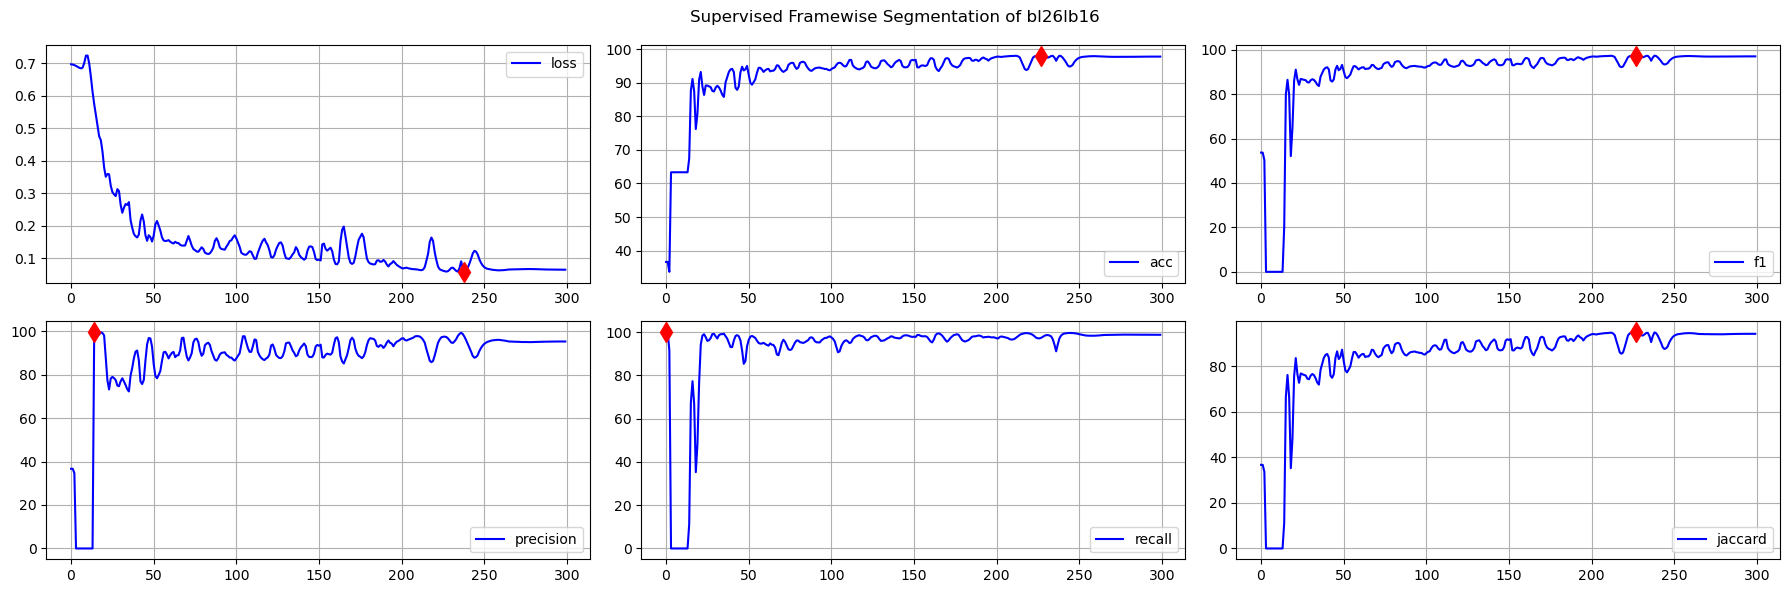

In [ ]:
plot_history(history, bird, model_type='Supervised')

In [26]:
test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, validation=True), batch_size=4, num_workers=1, shuffle=False, pin_memory=False, collate_fn=pad_collate_fn)
with torch.inference_mode():
    model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

bl26lb16:  loss=0.0625, acc=97.8647, f1=96.9558, prc=95.2857, rec=98.6855, jac=94.0915


### Semi-Supervised (Mean Teacher)

In [21]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn, persistent_workers=True)
train_loader_unsup = DataLoader(BengaleseMeanTeacherSegmentationDataset(unsfiles, sample_dur=5), batch_size=32, num_workers=4, shuffle=True, pin_memory=True, collate_fn=mean_teacher_pad_collate_fn, persistent_workers=True)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, sample_dur=-1, validation=True), batch_size=4, num_workers=2, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [22]:
Epochs = 300
student_model = ConvRNNSegmentor(p_dropout=0.3).to(DEVICE).train()
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
teacher_model = ConvRNNSegmentor(p_dropout=0.).to(DEVICE).train()
for param in teacher_model.parameters():
    param.detach_()

print(f'#parameters: {sum([p.numel() for p in teacher_model.parameters()]):_}')

#parameters: 487_617


In [23]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_SemiSupervised(MeanTeacher)'
dataset_name = f'BengaleseFinch_5shots'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/bl26lb16_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/bl26lb16_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shots_300E.pt


In [24]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []
    train_loader_sup_iter = iter(train_loader_sup)
    for x_stu, x_tea in train_loader_unsup:
        try:
            x, y = next(train_loader_sup_iter)
        except StopIteration:
            train_loader_sup_iter = iter(train_loader_sup)
            x, y = next(train_loader_sup_iter)
        x_stu, x_tea, x, y = x_stu.to(DEVICE), x_tea.to(DEVICE), x.to(DEVICE), y.to(DEVICE)
        rampup_weight = sigmoid_rampup(e+1, rampup_length=100)
        optimizer.zero_grad() 
        
        # supervised calculation
        logits = student_model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss_sup = bxe_with_ignore(logits, y, ignore=-1)
        
        # semi-supervised calculation
        # get teacher soft predictions
        with torch.no_grad():
            tea_logits = teacher_model(x_tea)
            tea_probs = torch.sigmoid(tea_logits).squeeze(-1).data
            # for mitigating the confirmation bias we only accept confident pseudo-labels in training the segmentation head
            tea_probs[torch.where((tea_probs > 0.2) & (tea_probs < 0.8))] = -1.0   
        stu_logits = student_model(x_stu).squeeze(-1)
        consistency_loss = rampup_weight * bxe_with_ignore(stu_logits, tea_probs, ignore=-1)
        if torch.isnan(consistency_loss):
            consistency_loss = 0.
        
        loss = loss_sup + consistency_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if (e+1) > 200:
            update_teacher(student_model, teacher_model, alpha=0.999)
        else:
            update_teacher(student_model, teacher_model, alpha=0.99)

        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
   
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    teacher_model.eval()
    val_mets = evaluate(teacher_model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5])
    
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    teacher_model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(teacher_model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 299 with jaccard score of 95.93350000000001


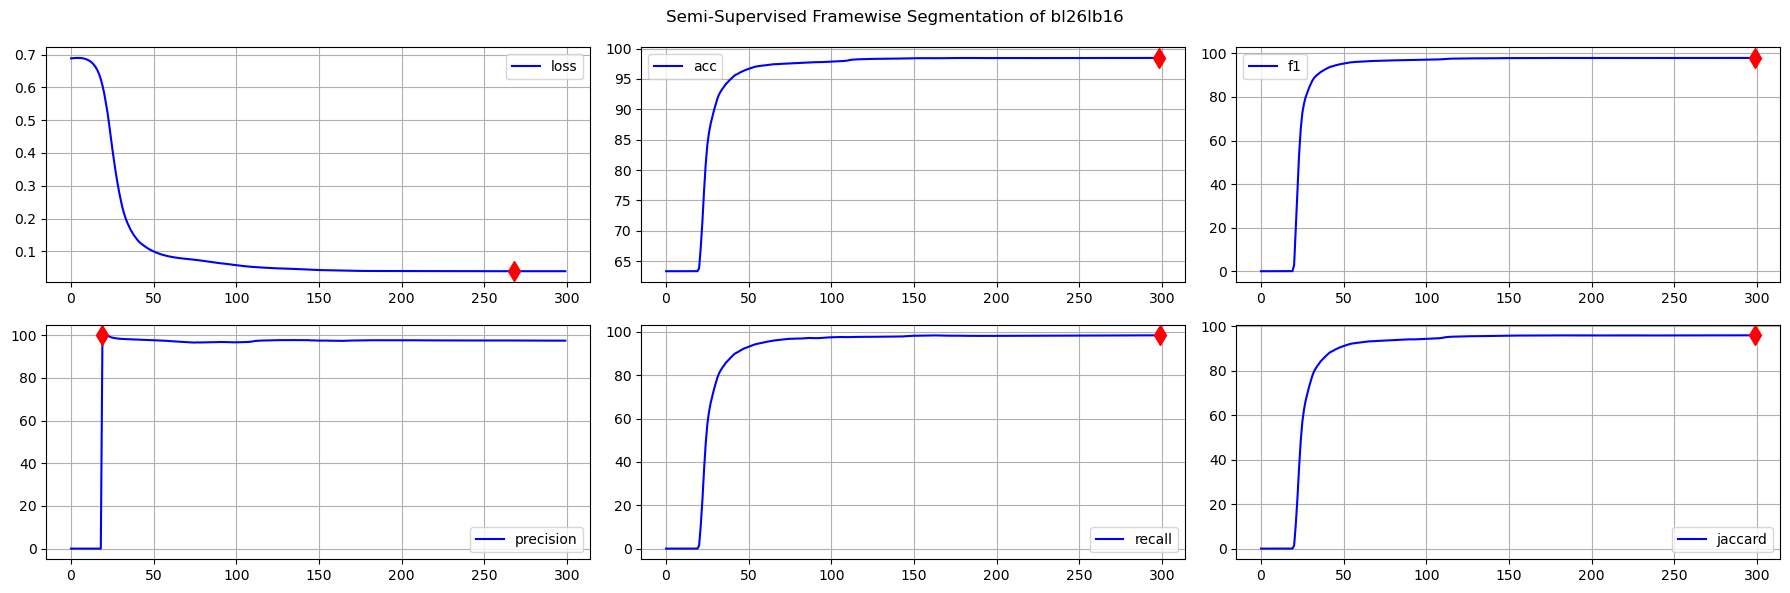

In [ ]:
plot_history(history, bird, 'Semi-Supervised')

In [26]:
test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, sample_dur=-1, validation=True), batch_size=4, num_workers=1, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    teacher_model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(teacher_model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

bl26lb16:  loss=0.0400, acc=98.5244, f1=97.8624, prc=97.6982, rec=98.0272, jac=95.8144


## gr41rd51

In [45]:
bird = 'gr41rd51'
np.random.seed(42)
random.seed(42)
num_shots = 5
supfiles = []
unsfiles = []

bird_files = bird2files[bird]
idx = np.random.permutation(len(bird_files))
supfiles.extend([bird_files[i] for i in idx[:num_shots]])
unsfiles.extend([bird_files[i] for i in idx[num_shots:]])
print(f'{bird}: {idx[:num_shots]}')

val_files = []
count = 0
while count < 16:
    file = random.choice(bird_files)
    if file not in supfiles:
        val_files.append(file)
        count +=1

total_dur, total_eff_dur = 0, 0
for file in supfiles:
    dur, eff_dur = get_bengalese_duration_and_effective_duration(file)
    total_dur += dur
    total_eff_dur += eff_dur
    print(file, f'duration (sec) = {dur:.3f}', f'duration of syllables (sec) = {eff_dur:.3f}', sep='  ')
print(round(total_dur, 3), round(total_eff_dur, 3))

gr41rd51: [667 324 623 689 521]
/home/acoust/hghaffar/Datasets/tweety/4805749/gr41rd51/062212/gr41rd51__3part_SYLc_th4191_belowhits_220612_0807.13824.cbin  duration (sec) = 15.774  duration of syllables (sec) = 3.213
/home/acoust/hghaffar/Datasets/tweety/4805749/gr41rd51/062212/gr41rd51__3part_SYLc_th4191_belowhits_220612_1250.15233.cbin  duration (sec) = 12.108  duration of syllables (sec) = 5.149
/home/acoust/hghaffar/Datasets/tweety/4805749/gr41rd51/062212/gr41rd51__3part_SYLc_th4191_belowhits_220612_0849.14121.cbin  duration (sec) = 14.688  duration of syllables (sec) = 6.724
/home/acoust/hghaffar/Datasets/tweety/4805749/gr41rd51/062312/gr41rd51__3part_SYLc_th4191_belowhits_230612_0846.17328.cbin  duration (sec) = 16.270  duration of syllables (sec) = 6.684
/home/acoust/hghaffar/Datasets/tweety/4805749/gr41rd51/062212/gr41rd51__3part_SYLc_th4191_belowhits_220612_1159.15028.cbin  duration (sec) = 13.774  duration of syllables (sec) = 5.533
72.614 27.303


### Thresholding

In [46]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_C(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: gr41rd51 
 acc=89.9618, f1=85.3982, precision=98.1122, recall=75.6014, jaccard=74.5174


In [47]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_B(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: gr41rd51 
 acc=96.9152, f1=95.9078, precision=98.8867, recall=93.1033, jaccard=92.1374


In [48]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_A(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: gr41rd51 
 acc=98.6185, f1=98.2508, precision=96.6271, recall=99.9301, jaccard=96.56179999999999


### Supervised

In [31]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, validation=True), batch_size=4, num_workers=2, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [29]:
Epochs = 300
model = ConvRNNSegmentor(p_dropout=.2).to(DEVICE).train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
print(f'#parameters: {sum([p.numel() for p in model.parameters()]):_}')

#parameters: 487_617


In [30]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_Supervised'
dataset_name = f'BengaleseFinch_5shots'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/gr41rd51_ConvRNNSegmentor_Supervised_BengaleseFinch_5shots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/gr41rd51_ConvRNNSegmentor_Supervised_BengaleseFinch_5shots_300E.pt


In [33]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []    
    for x, y in train_loader_sup:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss = bxe_with_ignore(logits, y, ignore=-1)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
        
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    model.eval()
    val_mets = evaluate(model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5]) 
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 281 with jaccard score of 93.5844


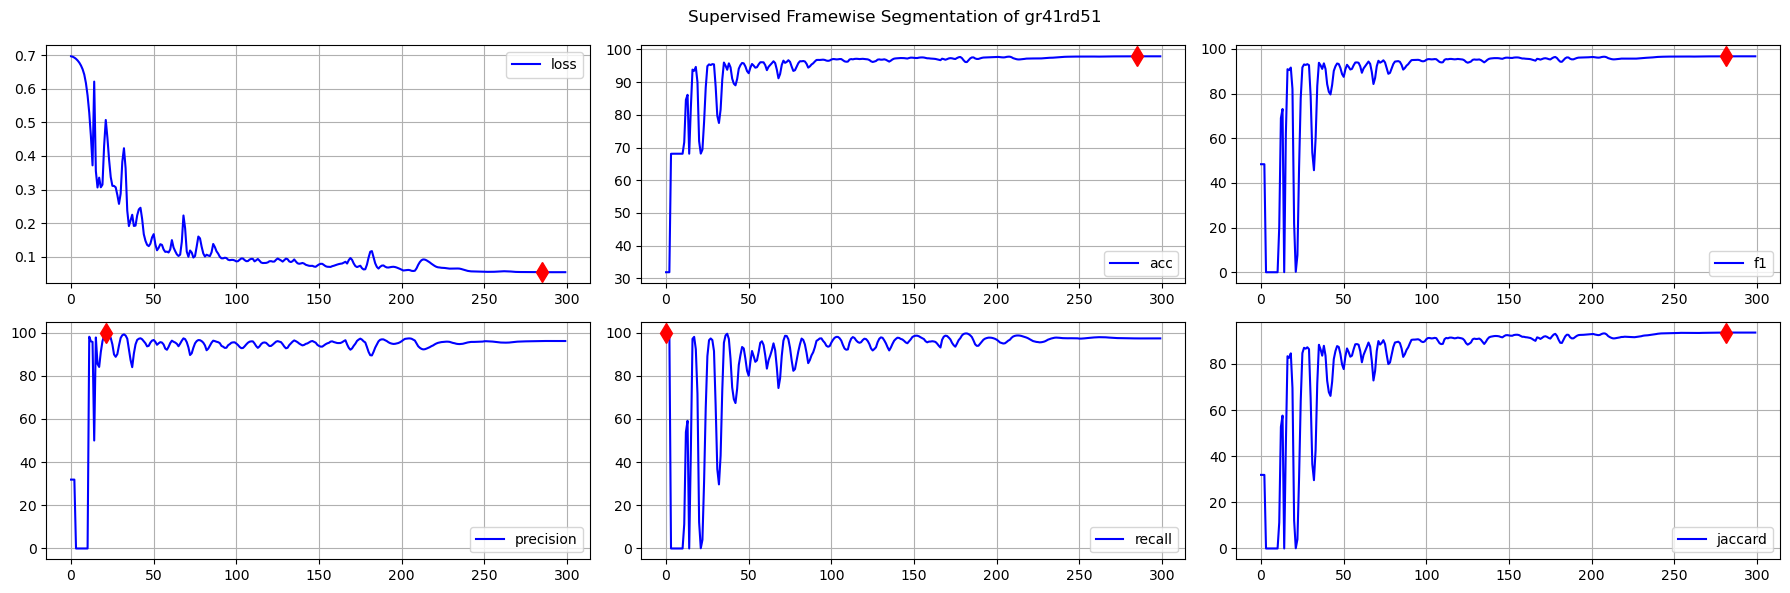

In [34]:
plot_history(history, bird, 'Supervised')

In [39]:
test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

gr41rd51:  loss=0.0441, acc=98.2944, f1=97.8123, prc=97.4302, rec=98.1974, jac=95.7182


### Semi-Supervised

In [21]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn, persistent_workers=True)
train_loader_unsup = DataLoader(BengaleseMeanTeacherSegmentationDataset(unsfiles, sample_dur=5), batch_size=32, num_workers=4, shuffle=True, pin_memory=True, collate_fn=mean_teacher_pad_collate_fn, persistent_workers=True)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, sample_dur=-1, validation=True), batch_size=4, num_workers=2, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [22]:
Epochs = 300
student_model = ConvRNNSegmentor(p_dropout=0.3).to(DEVICE).train()
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
teacher_model = ConvRNNSegmentor(p_dropout=0.).to(DEVICE).train()
for param in teacher_model.parameters():
    param.detach_()

print(f'#parameters: {sum([p.numel() for p in teacher_model.parameters()]):_}')

#parameters: 487_617


In [23]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_SemiSupervised(MeanTeacher)'
dataset_name = f'BengaleseFinch_5shots'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/gr41rd51_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/gr41rd51_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shots_300E.pt


In [24]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []
    train_loader_sup_iter = iter(train_loader_sup)
    for x_stu, x_tea in train_loader_unsup:
        try:
            x, y = next(train_loader_sup_iter)
        except StopIteration:
            train_loader_sup_iter = iter(train_loader_sup)
            x, y = next(train_loader_sup_iter)
        x_stu, x_tea, x, y = x_stu.to(DEVICE), x_tea.to(DEVICE), x.to(DEVICE), y.to(DEVICE)
        rampup_weight = sigmoid_rampup(e+1, rampup_length=100)
        optimizer.zero_grad() 
        
        # supervised calculation
        logits = student_model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss_sup = bxe_with_ignore(logits, y, ignore=-1)
        
        # semi-supervised calculation
        # get teacher soft predictions
        with torch.no_grad():
            tea_logits = teacher_model(x_tea)
            tea_probs = torch.sigmoid(tea_logits).squeeze(-1).data
            # for mitigating the confirmation bias we only accept confident pseudo-labels in training the segmentation head
            tea_probs[torch.where((tea_probs > 0.2) & (tea_probs < 0.8))] = -1.0   
        stu_logits = student_model(x_stu).squeeze(-1)
        consistency_loss = rampup_weight * bxe_with_ignore(stu_logits, tea_probs, ignore=-1)
        if torch.isnan(consistency_loss):
            consistency_loss = 0.
        
        loss = loss_sup + consistency_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if (e+1) > 200:
            update_teacher(student_model, teacher_model, alpha=0.999)
        else:
            update_teacher(student_model, teacher_model, alpha=0.99)

        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
   
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    teacher_model.eval()
    val_mets = evaluate(teacher_model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard, auc
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5])
    
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    teacher_model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(teacher_model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 144 with jaccard score of 97.7082


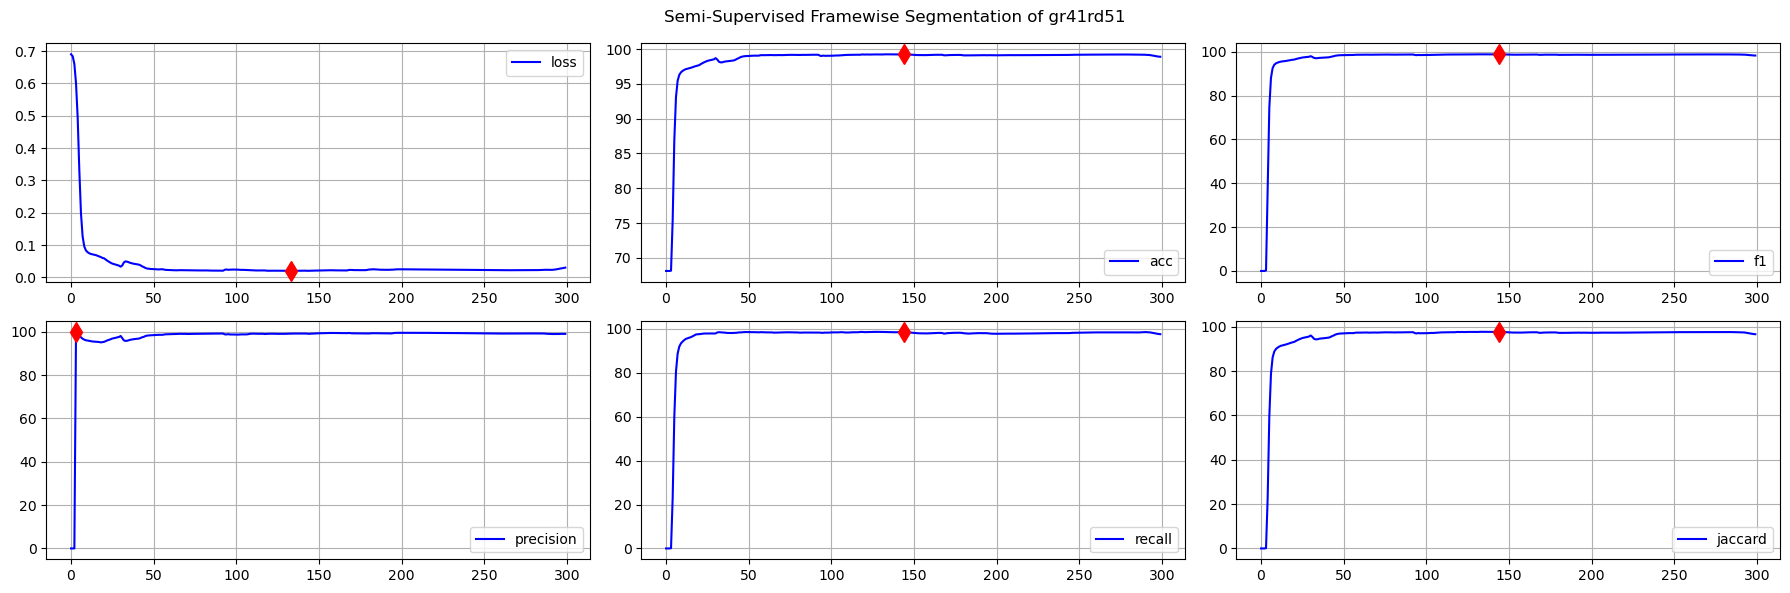

In [25]:
plot_history(history, bird, 'Semi-Supervised')

In [26]:
test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, sample_dur=-1, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    teacher_model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(teacher_model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

gr41rd51:  loss=0.0372, acc=98.6481, f1=98.2532, prc=98.5881, rec=97.9205, jac=96.5664


## gy6or6

In [49]:
bird = 'gy6or6'
np.random.seed(42)
random.seed(42)
num_shots = 5
supfiles = []
unsfiles = []
bird_files = bird2files[bird]
idx = np.random.permutation(len(bird_files))
supfiles.extend([bird_files[i] for i in idx[:num_shots]])
unsfiles.extend([bird_files[i] for i in idx[num_shots:]])
print(f'{bird}: {idx[:num_shots]}')

val_files = []
count = 0
while count < 16:
    file = random.choice(bird_files)
    if file not in supfiles:
        val_files.append(file)
        count +=1

total_dur, total_eff_dur = 0, 0
for file in supfiles:
    dur, eff_dur = get_bengalese_duration_and_effective_duration(file)
    total_dur += dur
    total_eff_dur += eff_dur
    print(file, f'duration (sec) = {dur:.3f}', f'duration of syllables (sec) = {eff_dur:.3f}', sep='  ')
print(round(total_dur, 3), round(total_eff_dur, 3))

gy6or6: [595 587 543 644 487]
/home/acoust/hghaffar/Datasets/tweety/4805749/gy6or6/032512/gy6or6_baseline_250312_1119.9.cbin  duration (sec) = 12.252  duration of syllables (sec) = 5.449
/home/acoust/hghaffar/Datasets/tweety/4805749/gy6or6/032312/gy6or6_baseline_230312_2000.703.cbin  duration (sec) = 12.173  duration of syllables (sec) = 5.787
/home/acoust/hghaffar/Datasets/tweety/4805749/gy6or6/032312/gy6or6_baseline_230312_0943.767.cbin  duration (sec) = 11.694  duration of syllables (sec) = 4.818
/home/acoust/hghaffar/Datasets/tweety/4805749/gy6or6/032412/gy6or6_baseline_240312_1411.3482.cbin  duration (sec) = 12.665  duration of syllables (sec) = 5.651
/home/acoust/hghaffar/Datasets/tweety/4805749/gy6or6/032412/gy6or6_baseline_240312_1641.4239.cbin  duration (sec) = 11.387  duration of syllables (sec) = 5.885
60.172 27.59


### Thresholding

In [50]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_C(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: gy6or6 
 acc=80.9803, f1=71.6764, precision=99.5324, recall=56.0029, jaccard=55.855900000000005


In [51]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_B(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: gy6or6 
 acc=93.4236, f1=91.7448, precision=99.5973, recall=85.04, jaccard=84.7486


In [52]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_A(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: gy6or6 
 acc=99.28439999999999, f1=99.1734, precision=98.459, recall=99.89829999999999, jaccard=98.3604


### Supervised

In [29]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, validation=True), batch_size=4, num_workers=2, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [30]:
Epochs = 300
model = ConvRNNSegmentor(p_dropout=.2).to(DEVICE).train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
print(f'#parameters: {sum([p.numel() for p in model.parameters()]):_}')

#parameters: 487_617


In [31]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_Supervised'
dataset_name = f'BengaleseFinch_5shots'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/gy6or6_ConvRNNSegmentor_Supervised_BengaleseFinch_5shots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/gy6or6_ConvRNNSegmentor_Supervised_BengaleseFinch_5shots_300E.pt


In [32]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []    
    for x, y in train_loader_sup:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss = bxe_with_ignore(logits, y, ignore=-1)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
        
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    model.eval()
    val_mets = evaluate(model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5]) 
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 246 with jaccard score of 95.05590000000001


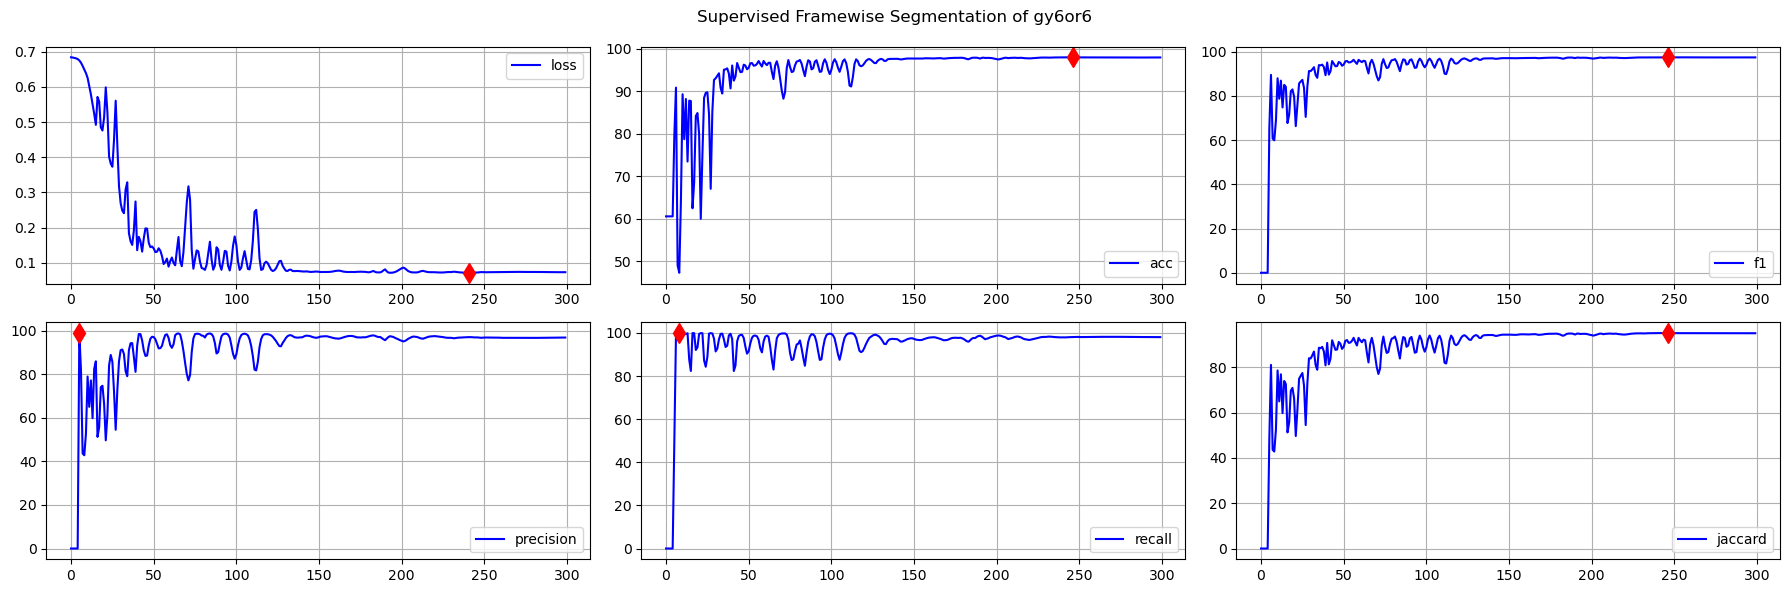

In [33]:
plot_history(history, bird, 'Supervised')

In [34]:
test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

gy6or6:  loss=0.0548, acc=98.1623, f1=97.8684, prc=97.5679, rec=98.1707, jac=95.8258


### Semi-Supervised

In [21]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn, persistent_workers=True)
train_loader_unsup = DataLoader(BengaleseMeanTeacherSegmentationDataset(unsfiles, sample_dur=5), batch_size=32, num_workers=4, shuffle=True, pin_memory=True, collate_fn=mean_teacher_pad_collate_fn, persistent_workers=True)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, sample_dur=-1, validation=True), batch_size=4, num_workers=2, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [22]:
Epochs = 300
student_model = ConvRNNSegmentor(p_dropout=0.3).to(DEVICE).train()
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
teacher_model = ConvRNNSegmentor(p_dropout=0.).to(DEVICE).train()
for param in teacher_model.parameters():
    param.detach_()

print(f'#parameters: {sum([p.numel() for p in teacher_model.parameters()]):_}')

#parameters: 487_617


In [23]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_SemiSupervised(MeanTeacher)'
dataset_name = f'BengaleseFinch_5shots'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/gy6or6_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/gy6or6_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shots_300E.pt


In [24]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []
    train_loader_sup_iter = iter(train_loader_sup)
    for x_stu, x_tea in train_loader_unsup:
        try:
            x, y = next(train_loader_sup_iter)
        except StopIteration:
            train_loader_sup_iter = iter(train_loader_sup)
            x, y = next(train_loader_sup_iter)
        x_stu, x_tea, x, y = x_stu.to(DEVICE), x_tea.to(DEVICE), x.to(DEVICE), y.to(DEVICE)
        rampup_weight = sigmoid_rampup(e+1, rampup_length=100)
        optimizer.zero_grad() 
        
        # supervised calculation
        logits = student_model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss_sup = bxe_with_ignore(logits, y, ignore=-1)
        
        # semi-supervised calculation
        # get teacher soft predictions
        with torch.no_grad():
            tea_logits = teacher_model(x_tea)
            tea_probs = torch.sigmoid(tea_logits).squeeze(-1).data
            # for mitigating the confirmation bias we only accept confident pseudo-labels in training the segmentation head
            tea_probs[torch.where((tea_probs > 0.2) & (tea_probs < 0.8))] = -1.0   
        stu_logits = student_model(x_stu).squeeze(-1)
        consistency_loss = rampup_weight * bxe_with_ignore(stu_logits, tea_probs, ignore=-1)
        if torch.isnan(consistency_loss):
            consistency_loss = 0.
        
        loss = loss_sup + consistency_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if (e+1) > 200:
            update_teacher(student_model, teacher_model, alpha=0.999)
        else:
            update_teacher(student_model, teacher_model, alpha=0.99)

        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
   
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    teacher_model.eval()
    val_mets = evaluate(teacher_model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5])
    
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    teacher_model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(teacher_model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 111 with jaccard score of 96.1713


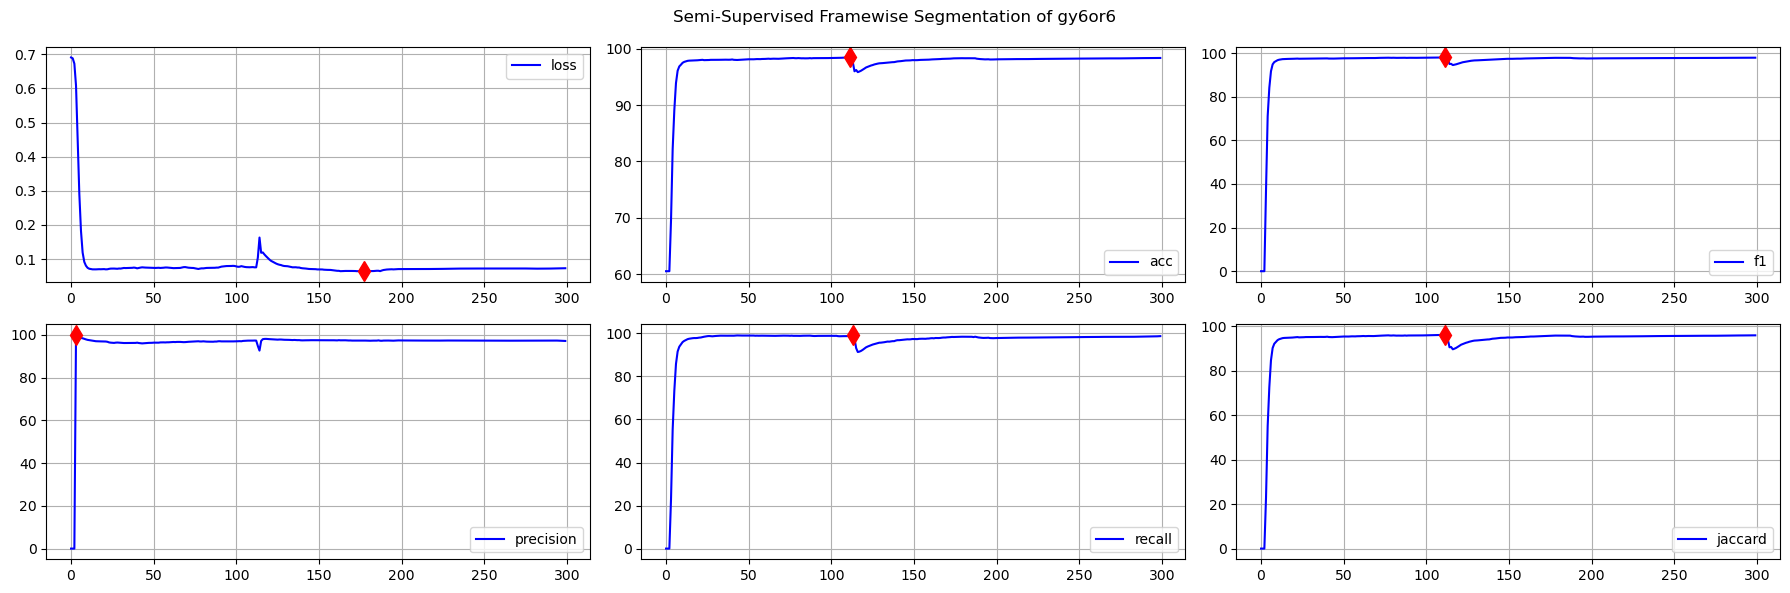

In [25]:
plot_history(history, bird, 'Semi-Supervised')

In [26]:
test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, sample_dur=-1, validation=True), batch_size=4, num_workers=1, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    teacher_model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(teacher_model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

gy6or6:  loss=0.0476, acc=98.5877, f1=98.3627, prc=98.0056, rec=98.7224, jac=96.7782


## or60yw70

In [53]:
bird = 'or60yw70'
np.random.seed(42)
random.seed(42)
num_shots = 5
supfiles = []
unsfiles = []
bird_files = bird2files[bird]
idx = np.random.permutation(len(bird_files))
supfiles.extend([bird_files[i] for i in idx[:num_shots]])
unsfiles.extend([bird_files[i] for i in idx[num_shots:]])
print(f'{bird}: {idx[:num_shots]}')

val_files = []
count = 0
while count < 16:
    file = random.choice(bird_files)
    if file not in supfiles:
        val_files.append(file)
        count +=1

total_dur, total_eff_dur = 0, 0
for file in supfiles:
    dur, eff_dur = get_bengalese_duration_and_effective_duration(file)
    total_dur += dur
    total_eff_dur += eff_dur
    print(file, f'duration (sec) = {dur:.3f}', f'duration of syllables (sec) = {eff_dur:.3f}', sep='  ')
print(round(total_dur, 3), round(total_eff_dur, 3))

or60yw70: [ 46 163  57  25 113]
/home/acoust/hghaffar/Datasets/tweety/4805749/or60yw70/093012/or60yw70_300912_1043.1546.cbin  duration (sec) = 9.728  duration of syllables (sec) = 4.414
/home/acoust/hghaffar/Datasets/tweety/4805749/or60yw70/092912/or60yw70_290912_1553.6926.cbin  duration (sec) = 13.708  duration of syllables (sec) = 5.479
/home/acoust/hghaffar/Datasets/tweety/4805749/or60yw70/093012/or60yw70_300912_1006.1359.cbin  duration (sec) = 10.426  duration of syllables (sec) = 4.162
/home/acoust/hghaffar/Datasets/tweety/4805749/or60yw70/093012/or60yw70_300912_2037.4177.cbin  duration (sec) = 6.569  duration of syllables (sec) = 1.777
/home/acoust/hghaffar/Datasets/tweety/4805749/or60yw70/092912/or60yw70_290912_1308.5973.cbin  duration (sec) = 12.431  duration of syllables (sec) = 5.549
52.862 21.381


### Thresholding

In [54]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_C(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: or60yw70 
 acc=86.7843, f1=81.6711, precision=99.1539, recall=69.42930000000001, jaccard=69.02040000000001


In [55]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_B(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: or60yw70 
 acc=97.134, f1=96.544, precision=98.7925, recall=94.3955, jaccard=93.3189


In [56]:
acc, f1, precision, recall, jaccard = evaluate_bengalese_by_thresholding_A(bird_files)
print(f'bird id: {bird} \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: or60yw70 
 acc=99.1804, f1=99.0424, precision=98.1573, recall=99.9437, jaccard=98.103


### Supervised

In [21]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, validation=True), batch_size=4, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [22]:
Epochs = 300
model = ConvRNNSegmentor(p_dropout=.2).to(DEVICE).train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
print(f'#parameters: {sum([p.numel() for p in model.parameters()]):_}')

#parameters: 487_617


In [23]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_Supervised'
dataset_name = f'BengaleseFinch_5shots'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/or60yw70_ConvRNNSegmentor_Supervised_BengaleseFinch_5shots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/or60yw70_ConvRNNSegmentor_Supervised_BengaleseFinch_5shots_300E.pt


In [24]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []    
    for x, y in train_loader_sup:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss = bxe_with_ignore(logits, y, ignore=-1)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
        
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    model.eval()
    val_mets = evaluate(model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5]) 
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 244 with jaccard score of 93.9308


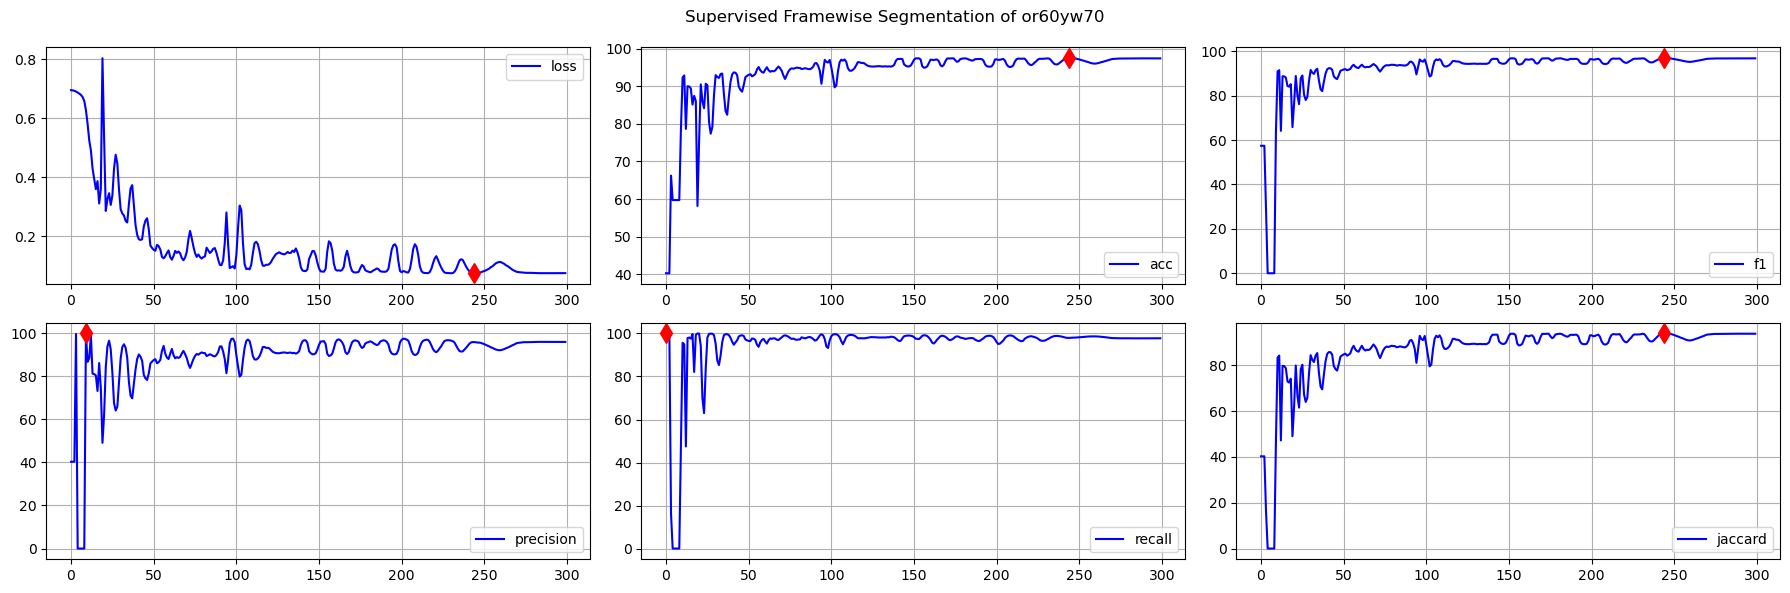

In [25]:
plot_history(history, bird, 'Supervised')

In [26]:
test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

or60yw70:  loss=0.0574, acc=97.9590, f1=97.5943, prc=97.5694, rec=97.6192, jac=95.3016


### Semi-Supervised

In [27]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn, persistent_workers=True)
train_loader_unsup = DataLoader(BengaleseMeanTeacherSegmentationDataset(unsfiles, sample_dur=5), batch_size=32, num_workers=4, shuffle=True, pin_memory=True, collate_fn=mean_teacher_pad_collate_fn, persistent_workers=True)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, sample_dur=-1, validation=True), batch_size=4, num_workers=2, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [28]:
Epochs = 300
student_model = ConvRNNSegmentor(p_dropout=0.3).to(DEVICE).train()
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
teacher_model = ConvRNNSegmentor(p_dropout=0.).to(DEVICE).train()
for param in teacher_model.parameters():
    param.detach_()

print(f'#parameters: {sum([p.numel() for p in teacher_model.parameters()]):_}')

#parameters: 487_617


In [29]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_SemiSupervised(MeanTeacher)'
dataset_name = f'BengaleseFinch_5shots'  # nospecaugment

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/or60yw70_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/or60yw70_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shots_300E.pt


In [30]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []
    train_loader_sup_iter = iter(train_loader_sup)
    for x_stu, x_tea in train_loader_unsup:
        try:
            x, y = next(train_loader_sup_iter)
        except StopIteration:
            train_loader_sup_iter = iter(train_loader_sup)
            x, y = next(train_loader_sup_iter)
        x_stu, x_tea, x, y = x_stu.to(DEVICE), x_tea.to(DEVICE), x.to(DEVICE), y.to(DEVICE)
        rampup_weight = sigmoid_rampup(e+1, rampup_length=100)
        optimizer.zero_grad() 
        
        # supervised calculation
        logits = student_model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss_sup = bxe_with_ignore(logits, y, ignore=-1)
        
        # semi-supervised calculation
        # get teacher soft predictions
        with torch.no_grad():
            tea_logits = teacher_model(x_tea)
            tea_probs = torch.sigmoid(tea_logits).squeeze(-1).data
            # for mitigating the confirmation bias we only accept confident pseudo-labels in training the segmentation head
            tea_probs[torch.where((tea_probs > 0.2) & (tea_probs < 0.8))] = -1.0   
        stu_logits = student_model(x_stu).squeeze(-1)
        consistency_loss = rampup_weight * bxe_with_ignore(stu_logits, tea_probs, ignore=-1)
        if torch.isnan(consistency_loss):
            consistency_loss = 0.
        
        loss = loss_sup + consistency_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if (e+1) > 200:
            update_teacher(student_model, teacher_model, alpha=0.999)
        else:
            update_teacher(student_model, teacher_model, alpha=0.99)

        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
   
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    teacher_model.eval()
    val_mets = evaluate(teacher_model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard, auc
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5])
    
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    teacher_model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(teacher_model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 299 with jaccard score of 96.4687


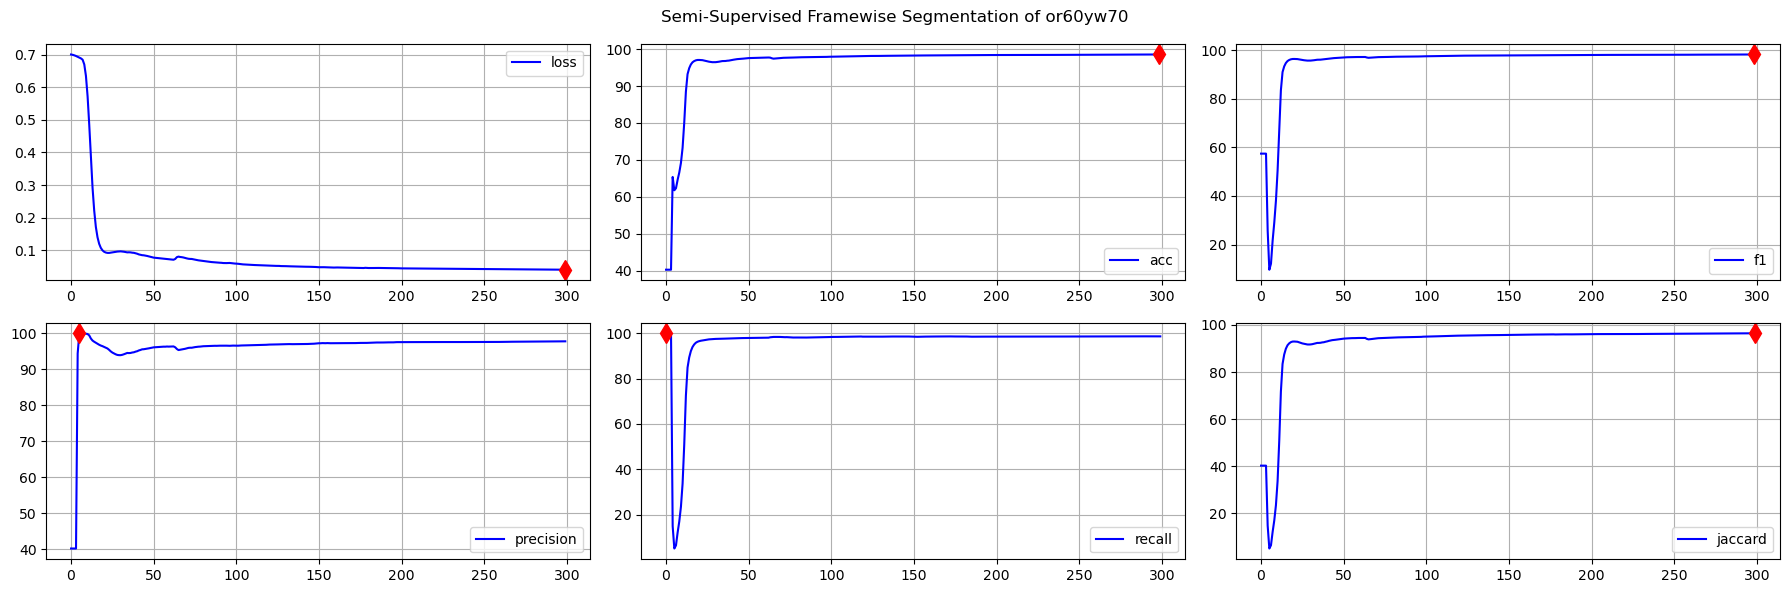

In [31]:
plot_history(history, bird, 'Semi-Supervised')

In [32]:
test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, sample_dur=-1, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    teacher_model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(teacher_model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

or60yw70:  loss=0.0346, acc=98.7232, f1=98.4945, prc=98.5028, rec=98.4863, jac=97.0337


## Species-Level Model

In [35]:
bird = 'AllBengalese'
np.random.seed(42)
random.seed(42)
num_shots = 5
supfiles = []
unsfiles = []
val_files = []
for key_bird, bird_files in bird2files.items():
    idx = np.random.permutation(len(bird_files))
    supfiles.extend([bird_files[i] for i in idx[:num_shots]])
    unsfiles.extend([bird_files[i] for i in idx[num_shots:]])
    print(f'{key_bird}: {idx[:num_shots]}')
    
    count = 0
    while count < 16:
        file = random.choice(bird_files)
        if file not in supfiles:
            val_files.append(file)
            count +=1

bl26lb16: [125  51 139  19 104]
gr41rd51: [295  70 630 506 702]
gy6or6: [567 154 539 115 453]
or60yw70: [117 228  67  62 234]


In [36]:
for file in supfiles:
    dur, eff_dur = get_bengalese_duration_and_effective_duration(file)
    print(file, f'duration (sec) = {dur:.3f}', f'duration of syllables (sec) = {eff_dur:.3f}', sep='  ')

/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/042012/bl26lb16_200412_1332.-31777.cbin  duration (sec) = 26.697  duration of syllables (sec) = 11.835
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/041912/bl26lb16_190412_0807.20240.cbin  duration (sec) = 16.059  duration of syllables (sec) = 1.507
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/041912/bl26lb16_190412_1351.22641.cbin  duration (sec) = 28.467  duration of syllables (sec) = 12.139
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/042112/bl26lb16_210412_0849.8312.cbin  duration (sec) = 10.575  duration of syllables (sec) = 1.401
/home/acoust/hghaffar/Datasets/tweety/4805749/bl26lb16/042012/bl26lb16_200412_0739.32173.cbin  duration (sec) = 23.238  duration of syllables (sec) = 1.047
/home/acoust/hghaffar/Datasets/tweety/4805749/gr41rd51/062212/gr41rd51__3part_SYLc_th4191_belowhits_220612_2020.16463.cbin  duration (sec) = 11.905  duration of syllables (sec) = 5.136
/home/acoust/hghaffar/Datasets/tw

### Supervised

In [29]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=8, num_workers=1, shuffle=True, pin_memory=True, collate_fn=pad_collate_fn, persistent_workers=False)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, validation=True), batch_size=4, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=False, collate_fn=pad_collate_fn)

In [30]:
Epochs = 300
model = ConvRNNSegmentor(p_dropout=.2).to(DEVICE).train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
print(f'#parameters: {sum([p.numel() for p in model.parameters()]):_}')

#parameters: 487_617


In [31]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_Supervised'
dataset_name = f'BengaleseFinch_5shotsEach'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/AllBengalese_ConvRNNSegmentor_Supervised_BengaleseFinch_5shotsEach_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/AllBengalese_ConvRNNSegmentor_Supervised_BengaleseFinch_5shotsEach_300E.pt


In [32]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []    
    for x, y in train_loader_sup:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss = bxe_with_ignore(logits, y, ignore=-1)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
        
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    model.eval()
    val_mets = evaluate(model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5])
    
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 275 with jaccard score of 96.59259999999999


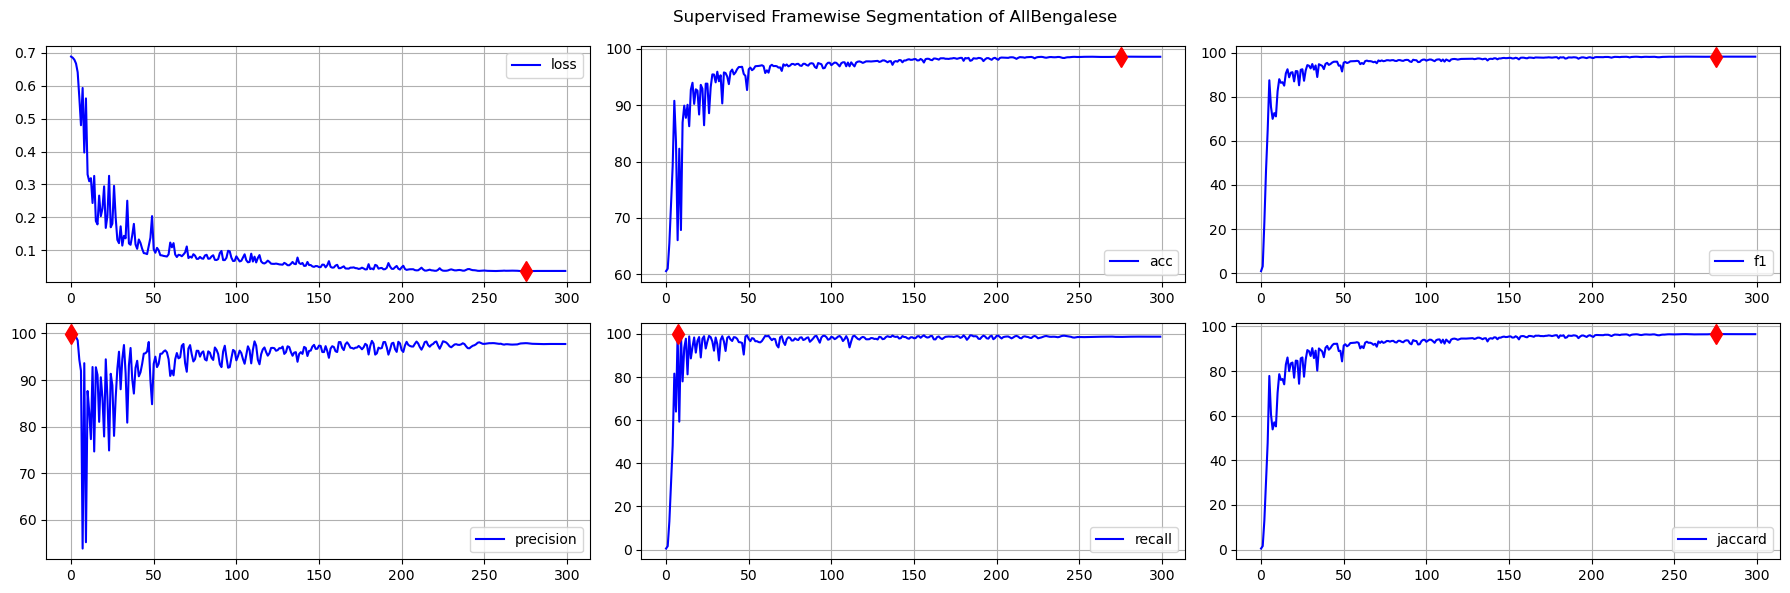

In [33]:
plot_history(history, bird, model_type='Supervised')

In [35]:
test_loader = DataLoader(BengaleseSegmentationDataset(unsfiles+supfiles, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

AllBengalese:  loss=0.0368, acc=98.6138, f1=98.2890, prc=97.8849, rec=98.6965, jac=96.6356


In [37]:
model.eval();
for key_bird, bird_files in bird2files.items():
    test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
    with torch.inference_mode():
        bird_log_path = log_path.split('.')[0] + f'_test_{key_bird}.csv'
        bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
        bird_mets = evaluate(model, test_loader)
        bird_history['loss'].append(bird_mets[0])
        bird_history['acc'].append(bird_mets[1])
        bird_history['f1'].append(bird_mets[2])
        bird_history['precision'].append(bird_mets[3])
        bird_history['recall'].append(bird_mets[4])
        bird_history['jaccard'].append(bird_mets[5])
        _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
        print(f'{key_bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

bl26lb16:  loss=0.0363, acc=98.6845, f1=98.0898, prc=98.1554, rec=98.0243, jac=96.2512
gr41rd51:  loss=0.0279, acc=98.9070, f1=98.5882, prc=98.8914, rec=98.2869, jac=97.2158
gy6or6:  loss=0.0448, acc=98.2904, f1=98.0334, prc=96.9357, rec=99.1562, jac=96.1426
or60yw70:  loss=0.0375, acc=98.5224, f1=98.2707, prc=97.5515, rec=99.0007, jac=96.6003


### Semi-Supervised (Mean Teacher)

In [26]:
train_loader_sup = DataLoader(BengaleseSegmentationDataset(supfiles, sample_dur=-1), batch_size=5, num_workers=1, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn, persistent_workers=True)
train_loader_unsup = DataLoader(BengaleseMeanTeacherSegmentationDataset(unsfiles, sample_dur=5), batch_size=32, num_workers=4, shuffle=True, pin_memory=True, collate_fn=mean_teacher_pad_collate_fn, persistent_workers=True)
val_loader = DataLoader(BengaleseSegmentationDataset(val_files, validation=True), batch_size=4, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [27]:
Epochs = 300
student_model = ConvRNNSegmentor(p_dropout=0.3).to(DEVICE).train()
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
teacher_model = ConvRNNSegmentor(p_dropout=0.).to(DEVICE).train()
for param in teacher_model.parameters():
    param.detach_()

print(f'#parameters: {sum([p.numel() for p in teacher_model.parameters()]):_}')

#parameters: 487_617


In [28]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_SemiSupervised(MeanTeacher)'
dataset_name = f'BengaleseFinch_5shotsEach'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
_ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/AllBengalese_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shotsEach_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/AllBengalese_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_BengaleseFinch_5shotsEach_300E.pt


In [29]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []
    train_loader_sup_iter = iter(train_loader_sup)
    for x_stu, x_tea in train_loader_unsup:
        try:
            x, y = next(train_loader_sup_iter)
        except StopIteration:
            train_loader_sup_iter = iter(train_loader_sup)
            x, y = next(train_loader_sup_iter)
        x_stu, x_tea, x, y = x_stu.to(DEVICE), x_tea.to(DEVICE), x.to(DEVICE), y.to(DEVICE)
        rampup_weight = sigmoid_rampup(e+1, rampup_length=100)
        optimizer.zero_grad() 
        
        # supervised calculation
        logits = student_model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss_sup = bxe_with_ignore(logits, y, ignore=-1)
        
        # semi-supervised calculation
        with torch.no_grad():
            tea_logits = teacher_model(x_tea)
            tea_probs = torch.sigmoid(tea_logits).squeeze(-1).data  # get teacher soft predictions
            # for mitigating the confirmation bias we only accept confident pseudo-labels in training
            tea_probs[torch.where((tea_probs > 0.2) & (tea_probs < 0.8))] = -1.0   
        stu_logits = student_model(x_stu).squeeze(-1)
        consistency_loss = rampup_weight * bxe_with_ignore(stu_logits, tea_probs, ignore=-1)
        if torch.isnan(consistency_loss):
            consistency_loss = 0.
        
        loss = loss_sup + consistency_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if (e+1) > 200:
            update_teacher(student_model, teacher_model, alpha=0.999)
        else:
            update_teacher(student_model, teacher_model, alpha=0.99)

        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
   
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
    teacher_model.eval()
    val_mets = evaluate(teacher_model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
    history['loss'].append(val_mets[0])
    history['acc'].append(val_mets[1])
    history['f1'].append(val_mets[2])
    history['precision'].append(val_mets[3])
    history['recall'].append(val_mets[4])
    history['jaccard'].append(val_mets[5])
    
    if val_mets[5] > best_score:
        best_score = val_mets[5]
        best_epoch = e
    teacher_model.train()

    tqdm_iterator.set_description(
        f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
        f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
        refresh=True)

print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
_ = pd.DataFrame(history).to_csv(log_path)
torch.save(teacher_model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

best epoch was 116 with jaccard score of 97.6326


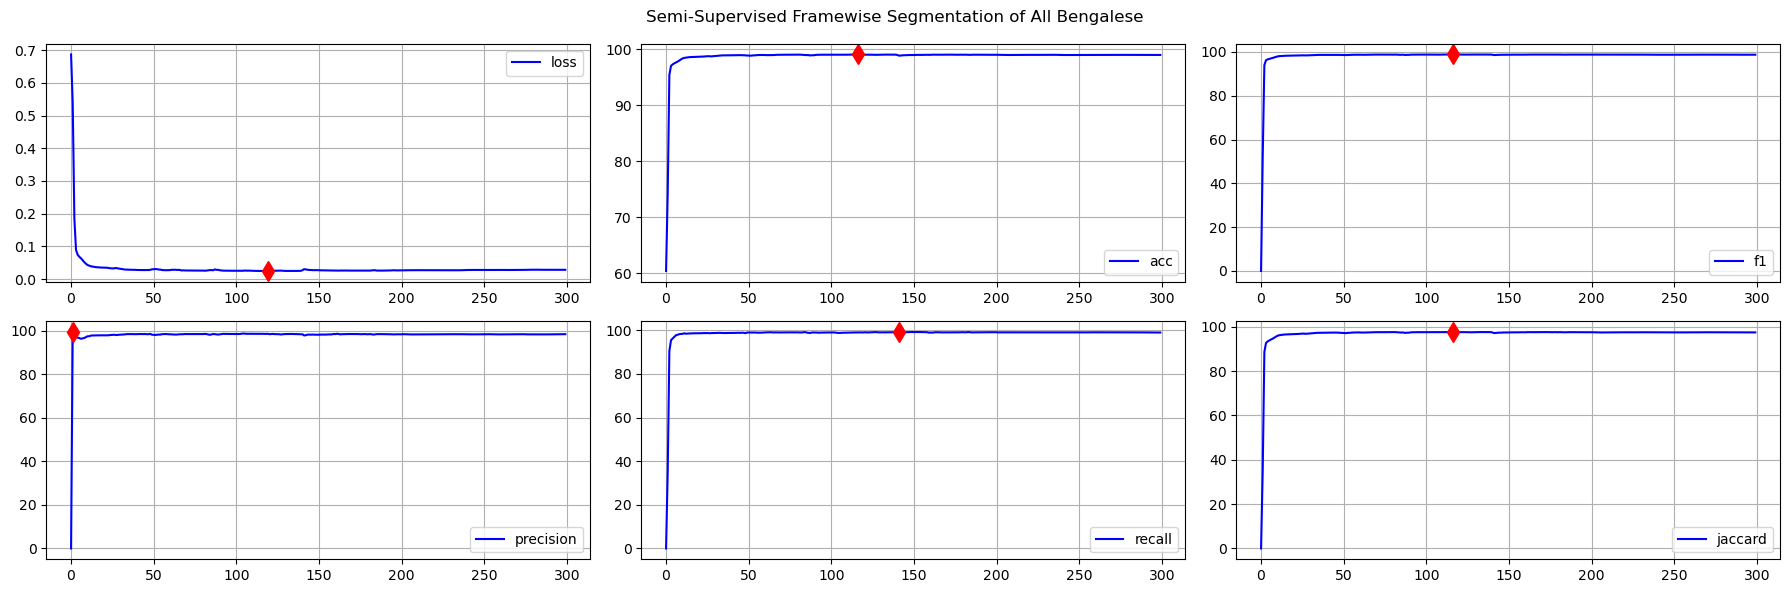

In [31]:
plot_history(history, 'All Bengalese', 'Semi-Supervised')

In [32]:
test_loader = DataLoader(BengaleseSegmentationDataset(unsfiles+supfiles, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
with torch.inference_mode():
    teacher_model.eval();
    bird_log_path = log_path.split('.')[0]+'_test.csv'
    bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
    bird_mets = evaluate(teacher_model, test_loader)
    bird_history['loss'].append(bird_mets[0])
    bird_history['acc'].append(bird_mets[1])
    bird_history['f1'].append(bird_mets[2])
    bird_history['precision'].append(bird_mets[3])
    bird_history['recall'].append(bird_mets[4])
    bird_history['jaccard'].append(bird_mets[5])
    _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
    print(f'{bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

AllBengalese:  loss=0.0262, acc=99.0578, f1=98.8331, prc=98.7603, rec=98.9060, jac=97.6931


In [33]:
teacher_model.eval();
for key_bird, bird_files in bird2files.items():
    test_loader = DataLoader(BengaleseSegmentationDataset(bird_files, validation=True), batch_size=4, num_workers=0, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
    with torch.inference_mode():
        bird_log_path = log_path.split('.')[0] + f'_test_{key_bird}.csv'
        bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
        bird_mets = evaluate(teacher_model, test_loader)
        bird_history['loss'].append(bird_mets[0])
        bird_history['acc'].append(bird_mets[1])
        bird_history['f1'].append(bird_mets[2])
        bird_history['precision'].append(bird_mets[3])
        bird_history['recall'].append(bird_mets[4])
        bird_history['jaccard'].append(bird_mets[5])
        _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
        print(f'{key_bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

bl26lb16:  loss=0.0352, acc=98.7425, f1=98.1786, prc=98.0011, rec=98.3568, jac=96.4224
gr41rd51:  loss=0.0205, acc=99.2529, f1=99.0396, prc=98.8655, rec=99.2143, jac=98.0975
gy6or6:  loss=0.0295, acc=98.9523, f1=98.7813, prc=98.7529, rec=98.8097, jac=97.5920
or60yw70:  loss=0.0236, acc=99.1161, f1=98.9582, prc=98.9214, rec=98.9951, jac=97.9379


# Canaries

In [11]:
class CanariesSegmentationDataset(Dataset):
    def __init__(self, df, sample_dur=5, sr=44100, n_fft=512, hop_length=64, validation=False):
        super().__init__()
        self.df = df
        self.sample_dur = sample_dur
        self.sr = sr
        self.path_to_recordings = df.audio_file.unique().tolist()
        self.file2labels = {}
        temp_grouped_df = df.groupby('audio_file')
        for file, group in temp_grouped_df:
            self.file2labels[file] = list(zip(group['onset_frame'], group['offset_frame']))
        assert np.isin(self.path_to_recordings, list(self.file2labels.keys())).all(), "missing labels for some files!"
        self.spec_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)
        self.hop = hop_length
        self.n_fft = n_fft
        self.validation = validation
        
    def __getitem__(self, idx):
        x, y = self.load_one(idx)
        x = x.transpose(1, 2)[0]  # (1, F, T) -> # (T, F)
        return x, y

    def __len__(self):
        return len(self.path_to_recordings)
    
    def load_one(self, idx):
        filename = self.path_to_recordings[idx]
        
        if self.sample_dur != -1:
            dur = librosa.get_duration(path=filename)  # duration in seconds
            # pick an offset in seconds and leave room fo at least prespecified sample duration afterward
            seconds_offset = 0 if dur < self.sample_dur else random.randint(0, int(dur - self.sample_dur))
            x, sr_ = librosa.load(filename, sr=None, offset=seconds_offset, duration=self.sample_dur)
            # number of the spectrogram frames for the whole audio file: I am doing this to avoid first computing long files spectrograms and then chopping them.
            # Instead, I first read the required amount to be fast in loading and processing. The reason for the below formula is that the usual floor(seconds * sr / hop)
            # gave inconsistent number of frames, probably due to how numbers are rounded and the spectrograms are calculated in the torchaudio. I tried this rounding and ceiling
            # below and it gave the correct number of total frames for all files.
            num_frames = math.ceil(round(dur, ndigits=4) * self.sr / self.hop)

        else:
            x, sr_ = librosa.load(filename, sr=None, offset=0.0, duration=None)
            num_frames = None
            
        x = highpass_butterworth(x, cutoff=500, sr=sr_)
        x = torch.tensor(x.copy(), dtype=torch.float32).unsqueeze(0)
        
        if not self.validation:
            x = x * random.uniform(0.5, 1.5)  # random gain
            x = x + (0.01 * random.random() * torch.randn(x.shape))  # gaussian noise
            
        x = normalize(self.db_transform(self.spec_transform(x)), 0, 1)
        if num_frames is None:
            num_frames = x.shape[-1]
            
        y = torch.zeros(num_frames, dtype=torch.float32)
        on_off_sets = self.file2labels[filename]
        for on, off in on_off_sets:
            y[on-1] = 0
            y[on:off+1] = 1.
        
        if self.sample_dur != -1:
            frames_offset = math.floor(seconds_offset * self.sr / self.hop)
            y = y[frames_offset:frames_offset+x.shape[-1]]
        assert y.shape[0] == x.shape[-1], "mismatch between input and label lengths!"
        x = x[:, 1:, :]  # drop dc
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
        return x, y


def pad_collate_fn(batch):
    spectrograms, labels = zip(*batch)
    spectrograms = pad_sequence(spectrograms, batch_first=True, padding_value=0.)
    spectrograms = spectrograms.transpose(1, 2).unsqueeze(1)  # (B, T, F) -> (B, 1, F, T)
    labels = pad_sequence(labels, batch_first=True, padding_value=-1) # (B, T)
    return spectrograms, labels

In [12]:
class CanariesMeanTeacherSegmentationDataset(Dataset):
    def __init__(self, df, sample_dur=5, sr=44100, n_fft=512, hop_length=64):
        super().__init__()
        self.df = df
        self.sample_dur = sample_dur
        self.sr = sr
        self.path_to_recordings = df.audio_file.unique().tolist()
        self.spec_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)
        self.hop = hop_length
        self.n_fft = n_fft
        
    def __getitem__(self, idx):
        x_stu, x_tea = self.load_one(idx)
        x_stu = x_stu.transpose(1, 2)[0]  # (1, F, T) -> # (T, F)
        x_tea = x_tea.transpose(1, 2)[0]  # (1, F, T) -> # (T, F)
        return x_stu, x_tea

    def __len__(self):
        return len(self.path_to_recordings)

    def load_one(self, idx):
        filename = self.path_to_recordings[idx]
        dur = librosa.get_duration(path=filename)
        offset = 0 if dur < self.sample_dur else random.randint(0, int(dur - self.sample_dur))
        x, sr_ = librosa.load(filename, sr=None, offset=offset, duration=self.sample_dur)
        x = highpass_butterworth(x, cutoff=500, sr=sr_)
        x = torch.tensor(x.copy(), dtype=torch.float32).unsqueeze(0)
        
        x_stu = x * random.uniform(0.5, 1.5)  # random gain
        x_tea = x * random.uniform(0.8, 1.2)
        
        x_stu = x_stu + (0.1 * random.random() * torch.randn(x_stu.shape))  # gaussian noise
        x_tea = x_tea + (0.01 * random.random() * torch.randn(x_tea.shape))
        
        x_stu = normalize(self.db_transform(self.spec_transform(x_stu)), 0, 1)
        x_tea = normalize(self.db_transform(self.spec_transform(x_tea)), 0, 1)
        
        x_stu = x_stu[:, 1:, :]
        x_tea = x_tea[:, 1:, :]
        x_stu = torch.nan_to_num(x_stu, nan=0.0, posinf=1., neginf=0.)
        x_tea = torch.nan_to_num(x_tea, nan=0.0, posinf=1., neginf=0.)
        return x_stu, x_tea


def mean_teacher_pad_collate_fn(batch):
    x_stu, x_tea = zip(*batch)
    x_stu = pad_sequence(x_stu, batch_first=True, padding_value=0.)
    x_tea = pad_sequence(x_tea, batch_first=True, padding_value=0.)
    x_stu = x_stu.transpose(1, 2).unsqueeze(1)  # (B, T, F) -> (B, 1, F, T)
    x_tea = x_tea.transpose(1, 2).unsqueeze(1)  # (B, T, F) -> (B, 1, F, T)
    return x_stu, x_tea

In [13]:
np.random.seed(42)
random.seed(42)
root_dir = Path("/path/to/datasets/canaries/doi_10.5061_dryad.xgxd254f4__v8/")
bird2dfs = {'llb11': None, 'llb16': None, 'llb3': None}
val_files = []
for bird in bird2dfs.keys():
    path_to_data = root_dir.joinpath(bird + '_data', bird + '_annot.csv')
    df = pd.read_csv(path_to_data)
    sampled_files = np.random.choice(df.audio_file.unique(), size=300, replace=False)
    df = df.loc[df.audio_file.isin(sampled_files)]
    df = df.reset_index(drop=True)
    # Canary files sampling rate is 44.1 kHz and I will consistently use a hop lenght of 64 everywhere (Both for Canaries and Bengalese Finches)
    # Adding these two columns to the data frames helps to have a faster and less complex pytorch Dataset for Canaries
    df['onset_frame'] = df.onset_s.map(lambda x: math.floor(x * 44100 / 64))  # 64 is the hop length
    df['offset_frame'] = df.offset_s.map(lambda x: math.ceil(x * 44100 / 64))
    
    df['audio_file'] = df['audio_file'].apply(lambda f: root_dir.joinpath(bird + '_data', bird + '_songs', f))
    
    df['set'] = 'test'
    df['bird'] = bird
    
    # I will make sure at least one example of each syllable is present in the few songs that I will use for the training
    num_of_bird_unique_lables = df.label.unique().shape[0]
    already_included_bird_labels = set()
    selected_files = []
    dur = 0
    
    # each audio file in the dataframe spans multiple rows for the info of each one of the syllables in that file (onset, offset, label, etc.) 
    df_grouped_by_filename = df.groupby('audio_file')
    for file, group in df_grouped_by_filename:
        
        if file in selected_files:
            raise ValueError("redundant file in the dataframe!")
        
        if len(already_included_bird_labels) == num_of_bird_unique_lables: # stop adding to train set when we had one example of each syllable
            break
        
        if already_included_bird_labels.issuperset(group.label.unique()): # if this audio file has no new label ignore it
            continue
        else:
            selected_files.append(file)
            already_included_bird_labels.update(group.label.unique())
            dur += (group['offset_s']-group['onset_s']).sum()
    
    # change the membership of the selected files from the test set to the train set
    df.loc[df.audio_file.isin(selected_files), 'set'] = 'train'
    print(f'{bird} : {len(selected_files)} songs', sep='\t')
    print(f'labels: {already_included_bird_labels}', sep='\t')
    print(f'effective duration of syllables: {dur}')
    bird2dfs[bird] = df.copy()
    val_files.extend(df[df.set == 'test'].audio_file.unique()[:16].tolist())
# merge all three canaries dataframes into one overall dataframe
df = pd.concat([df for df in bird2dfs.values()], ignore_index=True)
df_train = df[df.set == 'train'].copy()
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle, but not really necessary though, it's not important.
df_test = df[df.set == 'test'].copy()
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_val = df_test.loc[df_test.audio_file.isin(val_files)].copy()
df_val = df_val.reset_index(drop=True)

llb11 : 7 songs
labels: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}
effective duration of syllables: 77.87091942067076
llb16 : 11 songs
labels: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
effective duration of syllables: 62.76971682062947
llb3 : 11 songs
labels: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
effective duration of syllables: 74.22138160958106


In [14]:
print("#syllabels: ", df_train.shape, df_test.shape, df_val.shape) 
print("#songs (files actually!): ", df_val.audio_file.unique().shape, df_train.audio_file.unique().shape, df_test.audio_file.unique().shape)

#syllabels:  (4904, 13) (136727, 13) (6305, 13)
#songs (files actually!):  (48,) (29,) (871,)


## Species-Level Model

In [14]:
bird = 'All_Canaries'

### Thresholding

In [97]:
bird_df = df[df.bird == 'llb11'].copy()
bird_df = bird_df.reset_index(drop=True)

In [70]:
acc, f1, precision, recall, jaccard = evaluate_canaries_by_thresholding_C(bird_df)
print(f'llb11 \n acc={acc}, f1={f1}, precision={precision}, recall={recall}, jaccard={jaccard}')

bird id: llb3 
 acc=83.79480000000001, f1=68.0664, precision=97.6086, recall=52.2518, jaccard=51.5914


In [98]:
acc, f1, precision, recall, jaccard = evaluate_canaries_by_thresholding_B(bird_df)
print(f'llb11 \n acc={acc:0.2f}, f1={f1:0.2f}, precision={precision:0.2f}, recall={recall:0.2f}, jaccard={jaccard:0.2f}')

llb11 
 acc=91.27, f1=85.80, precision=92.79, recall=79.79, jaccard=75.13


In [99]:
bird_df = df[df.bird == 'llb3'].copy()
bird_df = bird_df.reset_index(drop=True)

In [100]:
acc, f1, precision, recall, jaccard = evaluate_canaries_by_thresholding_C(bird_df)
print(f'llb3 \n acc={acc:0.2f}, f1={f1:0.2f}, precision={precision:0.2f}, recall={recall:0.2f}, jaccard={jaccard:0.2f}')

llb3 
 acc=74.47, f1=70.36, precision=98.98, recall=54.58, jaccard=54.28


In [101]:
acc, f1, precision, recall, jaccard = evaluate_canaries_by_thresholding_B(bird_df)
print(f'llb3 \n acc={acc:0.2f}, f1={f1:0.2f}, precision={precision:0.2f}, recall={recall:0.2f}, jaccard={jaccard:0.2f}')

llb3 
 acc=91.04, f1=91.56, precision=95.96, recall=87.54, jaccard=84.43


In [102]:
bird_df = df[df.bird == 'llb16'].copy()
bird_df = bird_df.reset_index(drop=True)

In [103]:
acc, f1, precision, recall, jaccard = evaluate_canaries_by_thresholding_C(bird_df)
print(f'llb16 \n acc={acc:0.2f}, f1={f1:0.2f}, precision={precision:0.2f}, recall={recall:0.2f}, jaccard={jaccard:0.2f}')

llb16 
 acc=86.18, f1=77.04, precision=99.32, recall=62.92, jaccard=62.65


In [104]:
acc, f1, precision, recall, jaccard = evaluate_canaries_by_thresholding_B(bird_df)
print(f'llb16 \n acc={acc:0.2f}, f1={f1:0.2f}, precision={precision:0.2f}, recall={recall:0.2f}, jaccard={jaccard:0.2f}')

llb16 
 acc=92.80, f1=89.62, precision=95.61, recall=84.35, jaccard=81.20


### Supervised

In [22]:
train_loader_sup = DataLoader(CanariesSegmentationDataset(df_train, sample_dur=-1), batch_size=4, num_workers=1, shuffle=True, pin_memory=True, collate_fn=pad_collate_fn, persistent_workers=True)
# val_loader = DataLoader(CanariesSegmentationDataset(df_val, sample_dur=-1, validation=True), batch_size=8, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [23]:
Epochs = 300
model = ConvRNNSegmentor(p_dropout=.2).to(DEVICE).train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
print(f'#parameters: {sum([p.numel() for p in model.parameters()]):_}')

#parameters: 487_617


In [25]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_Supervised'
dataset_name = f'Canaries_fewshot'
log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

# history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
# _ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/All_Canaries_ConvRNNSegmentor_Supervised_Canaries_fewshot_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/All_Canaries_ConvRNNSegmentor_Supervised_Canaries_fewshot_300E.pt


In [26]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []    
    for x, y in train_loader_sup:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss = bxe_with_ignore(logits, y, ignore=-1)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
        
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
#     model.eval()
#     val_mets = evaluate(model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
#     history['loss'].append(val_mets[0])
#     history['acc'].append(val_mets[1])
#     history['f1'].append(val_mets[2])
#     history['precision'].append(val_mets[3])
#     history['recall'].append(val_mets[4])
#     history['jaccard'].append(val_mets[5])
    
#     if val_mets[5] > best_score:
#         best_score = val_mets[5]
#         best_epoch = e
#     model.train()

    # tqdm_iterator.set_description(
    #     f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
    #     f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
    #     refresh=True)
    tqdm_iterator.set_description(f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f}", refresh=True)
# print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
# _ = pd.DataFrame(history).to_csv(log_path)
torch.save(model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

In [1]:
# plot_history(history, bird, model_type="Supervised")

In [28]:
model.eval()
grouped_df = df.groupby('bird')
for key_bird, bird_df in grouped_df:
    test_loader = DataLoader(CanariesSegmentationDataset(bird_df, sample_dur=-1, validation=True), batch_size=4, num_workers=4, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
    with torch.inference_mode():
        bird_log_path = log_path.split('.')[0] + f'_test_{key_bird}.csv'
        bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
        bird_mets = evaluate(model, test_loader)
        bird_history['loss'].append(bird_mets[0])
        bird_history['acc'].append(bird_mets[1])
        bird_history['f1'].append(bird_mets[2])
        bird_history['precision'].append(bird_mets[3])
        bird_history['recall'].append(bird_mets[4])
        bird_history['jaccard'].append(bird_mets[5])
        _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
        print(f'{key_bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

llb11:  loss=0.0449, acc=98.3454, f1=97.4062, prc=96.5005, rec=98.3290, jac=94.9435
llb16:  loss=0.0526, acc=98.0485, f1=97.3692, prc=96.8086, rec=97.9363, jac=94.8733
llb3:  loss=0.0961, acc=96.6540, f1=97.0031, prc=95.6555, rec=98.3893, jac=94.1807


In [53]:
target_names = ['bg', 'syllable']
with torch.no_grad():
    for key_bird, bird_df in bird2dfs.items():
        test_loader = DataLoader(CanariesSegmentationDataset(bird_df.copy(), sample_dur=-1, validation=True), batch_size=4, num_workers=1, shuffle=False, pin_memory=False, collate_fn=pad_collate_fn)
        y_true, y_pred = [], []
        for x, y in tqdm(test_loader):
            x = x.to(DEVICE)
            logits = model(x)  # (B, T, C)
            y_true.append(y.detach().flatten().tolist())
            y_pred.append(torch.sigmoid(logits).round().flatten().detach().cpu().tolist())

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        idx = np.where(y_true != -1.)[0]
        y_pred = y_pred[idx]
        y_true = y_true[idx]

    print(key_bird)
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    print()

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

llb3
              precision    recall  f1-score   support

          bg       0.96      0.95      0.95   9300372
    syllable       0.96      0.97      0.96  11606638

    accuracy                           0.96  20907010
   macro avg       0.96      0.96      0.96  20907010
weighted avg       0.96      0.96      0.96  20907010




### Semi-Supervised

In [15]:
train_loader_sup = DataLoader(CanariesSegmentationDataset(df_train, sample_dur=-1), batch_size=4, num_workers=1, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn, persistent_workers=True)
train_loader_unsup = DataLoader(CanariesMeanTeacherSegmentationDataset(df_test, sample_dur=5), batch_size=32, num_workers=8, shuffle=True, pin_memory=True, collate_fn=mean_teacher_pad_collate_fn, persistent_workers=True)
# val_loader = DataLoader(CanariesSegmentationDataset(df_val, sample_dur=-1, validation=True), batch_size=4, num_workers=1, shuffle=False, pin_memory=True, persistent_workers=True, collate_fn=pad_collate_fn)

In [16]:
Epochs = 300
student_model = ConvRNNSegmentor(p_dropout=0.31).to(DEVICE).train()
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
scheduler = RiseRunDecayScheduler(optimizer, steps_in_epoch=len(train_loader_sup), warmup=10, constant=140, total_epochs=Epochs, lowest_lr=1e-6)
teacher_model = ConvRNNSegmentor(p_dropout=0.).to(DEVICE).train()
for param in teacher_model.parameters():
    param.detach_()

print(f'#parameters: {sum([p.numel() for p in teacher_model.parameters()]):_}')

#parameters: 487_617


In [17]:
best_score = float('-inf')
best_epoch = 0
model_name = f'{bird}_ConvRNNSegmentor_SemiSupervised(MeanTeacher)'
dataset_name = f'Canaries_fewshots'

log_dir = os.path.join(os.path.abspath(os.path.curdir), "logs")
checkpoint_dir = os.path.join(os.path.abspath(os.path.curdir), "checkpoints")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
log_path = os.path.join(log_dir, f'{model_name}_{dataset_name}_{Epochs}E.csv')
checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_{dataset_name}_{Epochs}E.pt')
print(log_path)
print(checkpoint_path)

# history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
# _ = pd.DataFrame(history).to_csv(log_path)

/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/logs/All_Canaries_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_Canaries_fewshots_300E.csv
/home/acoust/hghaffar/Projects/BirdSongAnalysis/mean_teacher_segmentation_paper/song_based/notebook/checkpoints/All_Canaries_ConvRNNSegmentor_SemiSupervised(MeanTeacher)_Canaries_fewshots_300E.pt


In [18]:
tqdm_iterator = tqdm(range(Epochs))
for e in tqdm_iterator:
    train_loss, y_true, y_pred = [], [], []
    train_loader_sup_iter = iter(train_loader_sup)
    for x_stu, x_tea in train_loader_unsup:
        try:
            x, y = next(train_loader_sup_iter)
        except StopIteration:
            train_loader_sup_iter = iter(train_loader_sup)
            x, y = next(train_loader_sup_iter)
        x_stu, x_tea, x, y = x_stu.to(DEVICE), x_tea.to(DEVICE), x.to(DEVICE), y.to(DEVICE)
        rampup_weight = sigmoid_rampup(e+1, rampup_length=100)
        optimizer.zero_grad() 
        
        # supervised calculation
        logits = student_model(x)  # (B, T, 1)
        logits = logits.squeeze(2)  # (B, T)
        loss_sup = bxe_with_ignore(logits, y, ignore=-1)
        
        # semi-supervised calculation
        with torch.no_grad():
            tea_logits = teacher_model(x_tea)
            tea_probs = torch.sigmoid(tea_logits).squeeze(-1).data  # get teacher soft predictions
            # for mitigating the confirmation bias we only accept confident pseudo-labels in training
            tea_probs[torch.where((tea_probs > 0.2) & (tea_probs < 0.8))] = -1.0   
        stu_logits = student_model(x_stu).squeeze(-1)
        consistency_loss = rampup_weight * bxe_with_ignore(stu_logits, tea_probs, ignore=-1)
        if torch.isnan(consistency_loss):
            consistency_loss = 0.
        
        loss = loss_sup + consistency_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if (e+1) > 200:
            update_teacher(student_model, teacher_model, alpha=0.999)
        else:
            update_teacher(student_model, teacher_model, alpha=0.99)

        train_loss.append(loss.item())
        y_true.append(y.cpu().detach().flatten().tolist())
        y_pred.append(torch.sigmoid(logits).flatten().detach().cpu().tolist())
   
    train_loss = np.mean(train_loss)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    idx = np.where(y_true != -1.)[0]
    y_pred = y_pred[idx]
    y_true = y_true[idx]
    y_pred = y_pred.round()
    acc = round(np.mean(y_true==y_pred), ndigits=6) * 100
    f1 = round(metrics.f1_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    jaccard = round(metrics.jaccard_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    precision = round(metrics.precision_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    recall = round(metrics.recall_score(y_true, y_pred, average='binary', zero_division=0), ndigits=6) * 100
    
    # **NOTE: validate on very few samples with ground truth. In practice, we don't have this. I used it here to show the consistency of convergence.
    # In the paper, the model from the final epoch has been used on the test set to report the results, not from the best validation epoch.
    # We only saved the model from final epoch, as if there was no validation set.
#     teacher_model.eval()
#     val_mets = evaluate(teacher_model, val_loader)  # returns test_loss, acc, f1, precision, recall, jaccard
#     history['loss'].append(val_mets[0])
#     history['acc'].append(val_mets[1])
#     history['f1'].append(val_mets[2])
#     history['precision'].append(val_mets[3])
#     history['recall'].append(val_mets[4])
#     history['jaccard'].append(val_mets[5])
    
#     if val_mets[5] > best_score:
#         best_score = val_mets[5]
#         best_epoch = e
#     teacher_model.train()

    # tqdm_iterator.set_description(
    #     f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f} | "
    #     f"val: loss={val_mets[0]:3.4f}, acc={val_mets[1]:3.4f}, f1={val_mets[2]:3.4f}, prc={val_mets[3]:3.4f}, rec={val_mets[4]:3.4f}, jac={val_mets[5]:3.4f}",
    #     refresh=True)
    tqdm_iterator.set_description(f"loss={train_loss:3.4f}, acc={acc:3.4f}, f1={f1:3.4f}, prc={precision:3.4f}, rec={recall:3.4f}, jac={jaccard:3.4f}", refresh=True)

# print(f'best epoch was {best_epoch} with jaccard score of {best_score}')
# _ = pd.DataFrame(history).to_csv(log_path)
torch.save(teacher_model.state_dict(), checkpoint_path)

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
# plot_history(history, 'All Canaries', 'Semi-Supervised')

In [21]:
teacher_model.eval();
grouped_df = df.groupby('bird')
for key_bird, bird_df in grouped_df:
    test_loader = DataLoader(CanariesSegmentationDataset(bird_df, sample_dur=-1, validation=True), batch_size=4, num_workers=4, shuffle=False, pin_memory=True, collate_fn=pad_collate_fn)
    with torch.inference_mode():
        bird_log_path = log_path.split('.')[0] + f'_test_{key_bird}.csv'
        bird_history = {'loss': [], 'acc': [], 'f1': [], 'precision': [], 'recall': [], 'jaccard': []}
        bird_mets = evaluate(teacher_model, test_loader)
        bird_history['loss'].append(bird_mets[0])
        bird_history['acc'].append(bird_mets[1])
        bird_history['f1'].append(bird_mets[2])
        bird_history['precision'].append(bird_mets[3])
        bird_history['recall'].append(bird_mets[4])
        bird_history['jaccard'].append(bird_mets[5])
        _ = pd.DataFrame(bird_history).to_csv(bird_log_path)
        print(f'{key_bird}:  loss={bird_mets[0]:3.4f}, acc={bird_mets[1]:3.4f}, f1={bird_mets[2]:3.4f}, prc={bird_mets[3]:3.4f}, rec={bird_mets[4]:3.4f}, jac={bird_mets[5]:3.4f}')

llb11:  loss=0.0421, acc=98.4743, f1=97.5958, prc=97.1843, rec=98.0108, jac=95.3045
llb16:  loss=0.0497, acc=98.2067, f1=97.5738, prc=97.3590, rec=97.7895, jac=95.2625
llb3:  loss=0.0936, acc=96.7740, f1=97.1087, prc=95.8227, rec=98.4296, jac=94.3799
